In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
df=pd.read_excel('Bariatric Project Study Data 2025_mod.xlsx', sheet_name='Sheet1')

In [3]:
core_X_data=df[['gender', 'age', 'height', 'weight', 'bmi', 'family_hist_cnt', 'chronic_meds_cnt','procedure_category','antibiotics']].copy()
cm_cols= [col for col in df.columns if col.startswith('CM_')]

cm_data = df[cm_cols].fillna(0).astype(int)
cm_data
zero_only = [col for col in cm_data.columns if (cm_data[col] == 0).all()]
cm_data = cm_data.drop(columns=zero_only)

# finally, join the filtered CM_ data back into your core set
core_X_data = core_X_data.join(cm_data)
core_X_data.fillna(0, inplace=True)
print(core_X_data.isna().sum())  # should all be zero   

# inspect result
print("Dropped CM columns:", zero_only)
print("Remaining columns in CM data:", cm_data.columns.tolist())
# 1) Grab all the antibiotic dummy columns
ab_cols = [c for c in core_X_data.columns if c.startswith('antibiotics')]

# 2) Count zeros in each column
for col in ab_cols:
    n_zeros = (core_X_data[col] == 0).sum()
    print(f"{col}: {n_zeros} zeros out of {len(core_X_data)} rows")

# 3) (Bonus) How many rows have *no* antibiotic flagged?
no_ab_rows = (core_X_data[ab_cols].sum(axis=1) == 0).sum()
print(f"\nRows where ALL antibiotic dummies are 0 (i.e. original 0): {no_ab_rows}")



gender                0
age                   0
height                0
weight                0
bmi                   0
family_hist_cnt       0
chronic_meds_cnt      0
procedure_category    0
antibiotics           0
CM_AIDS               0
CM_ANEMDEF            0
CM_ARTH               0
CM_CHF                0
CM_DEPRESS            0
CM_DM                 0
CM_DMCX               0
CM_HTN_C              0
CM_HYPOTHY            0
CM_LIVER              0
CM_OBESE              0
CM_PSYCH              0
CM_SMOKE              0
CM_APNEA              0
CM_CHOLSTRL           0
CM_OSTARTH            0
CM_HPLD               0
dtype: int64
Dropped CM columns: ['CM_ALCOHOL', 'CM_BLDLOSS', 'CM_CHRNLUNG', 'CM_COAG', 'CM_DRUG', 'CM_LYMPH', 'CM_LYTES', 'CM_METS', 'CM_NEURO', 'CM_PARA', 'CM_PERIVASC', 'CM_PULMCIRC', 'CM_RENLFAIL', 'CM_TUMOR', 'CM_ULCER', 'CM_VALVE', 'CM_WGHTLOSS']
Remaining columns in CM data: ['CM_AIDS', 'CM_ANEMDEF', 'CM_ARTH', 'CM_CHF', 'CM_DEPRESS', 'CM_DM', 'CM_DMCX', 'CM_HTN_C', 

In [4]:
# Check whether CM_NEURO survived the filtering
if 'CM_CHF' in core_X_data.columns:
    print("CM_CHF is present in core_X_data!")
else:
    
    print("CM_CHFis NOT in core_X_data.")
if 'CM_DRUG' in core_X_data.columns:
    print("CM_NEURO is present in core_X_data!")
else:
    print("CM_NEURO is NOT in core_X_data.")


CM_CHF is present in core_X_data!
CM_NEURO is NOT in core_X_data.


In [5]:
# Identify all complication-related columns
comp_cols = [col for col in df.columns if 'comp' in col.lower()]

# Create new dataset without the original complication columns
df_new = df.drop(columns=comp_cols)

# Add a single 'complication' column: 1 if any original comp column == 1, else 0
df_new['complication'] = (df[comp_cols] == 1).any(axis=1).astype(int)

# Display new dataset shape
print("New dataset shape (rows, columns):", df_new.shape)

# Show a sample of the new 'complication' column alongside the ID
# Show the first 10 rows of id and complication
print(df_new[['id', 'complication']].head(10))
print("First 15 column names:", df_new.columns.tolist())

New dataset shape (rows, columns): (344, 111)
        id  complication
0  45488.0             0
1      NaN             0
2  37462.0             1
3  40661.0             0
4      NaN             0
5  40699.0             0
6  38920.0             0
7  37827.0             0
8  47189.0             0
9      NaN             0
First 15 column names: ['doctor', 'procedure_category', 'hospitalDesc', 'hospital_wardDesc', 'days_since_admission', 'length_of_stay', 'gender', 'age', 'weight', 'height', 'bmi', 'family_hist_cnt', 'chronic_meds_cnt', 'cm_count', 'morbidity', 'CM_AIDS', 'CM_ALCOHOL', 'CM_ANEMDEF', 'CM_ARTH', 'CM_BLDLOSS', 'CM_CHF', 'CM_CHRNLUNG', 'CM_COAG', 'CM_DEPRESS', 'CM_DM', 'CM_DMCX', 'CM_DRUG', 'CM_HTN_C', 'CM_HYPOTHY', 'CM_LIVER', 'CM_LYMPH', 'CM_LYTES', 'CM_METS', 'CM_NEURO', 'CM_OBESE', 'CM_PARA', 'CM_PERIVASC', 'CM_PSYCH', 'CM_PULMCIRC', 'CM_RENLFAIL', 'CM_SMOKE', 'CM_TUMOR', 'CM_ULCER', 'CM_VALVE', 'CM_WGHTLOSS', 'CM_APNEA', 'CM_CHOLSTRL', 'CM_OSTARTH', 'CM_HPLD', 'emergency_

In [6]:
# Missing values analysis
missing_df = pd.DataFrame({
    'Missing_Count': core_X_data.isnull().sum(),
    'Missing_Percentage': (core_X_data.isnull().sum() / len(core_X_data)) * 100
})
missing_df = missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)

print("="*50)
print("MISSING VALUES ANALYSIS")
print("="*50)
print(f"Columns with missing values: {len(missing_df)}/{core_X_data.shape[1]}")
print(f"Total completeness: {(1 - core_X_data.isnull().sum().sum()/(core_X_data.shape[0]*core_X_data.shape[1]))*100:.1f}%")

if len(missing_df) > 0:
    print("\nTop missing columns:")
    print(missing_df.head(10))
    
    # Visualization
    plt.figure(figsize=(10, 6))
    top_missing = missing_df.head(15)
    plt.barh(range(len(top_missing)), top_missing['Missing_Percentage'], color='coral')
    plt.yticks(range(len(top_missing)), top_missing.index)
    plt.xlabel('Missing Percentage (%)')
    plt.title('Top 15 Columns with Missing Values', fontsize=14, fontweight='bold')
    
    for i, v in enumerate(top_missing['Missing_Percentage']):
        plt.text(v + 0.1, i, f'{v:.1f}%', va='center')
    
    plt.tight_layout()
    plt.show()
else:
    print("No missing values found!")

MISSING VALUES ANALYSIS
Columns with missing values: 0/26
Total completeness: 100.0%
No missing values found!


In [7]:
core_Y_data=df_new[["complication"]]

core_Y_data.head()

,complication
0,0
1,0
2,1
3,0
4,0


In [8]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data
X = core_X_data.copy()
y = core_Y_data['complication'].values

# Handle categorical variables first
categorical_cols = X.select_dtypes(include=['object']).columns
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)


# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

print("Class distribution in training set:")
print(f"No complications: {(y_train==0).sum()} ({(y_train==0).sum()/len(y_train)*100:.1f}%)")
print(f"Complications: {(y_train==1).sum()} ({(y_train==1).sum()/len(y_train)*100:.1f}%)")
print(f"\nClass distribution in test set:")
print(f"No complications: {(y_test==0).sum()} ({(y_test==0).sum()/len(y_test)*100:.1f}%)")
print(f"Complications: {(y_test==1).sum()} ({(y_test==1).sum()/len(y_test)*100:.1f}%)")
X_encoded.head()

Class distribution in training set:
No complications: 248 (90.2%)
Complications: 27 (9.8%)

Class distribution in test set:
No complications: 62 (89.9%)
Complications: 7 (10.1%)


,age,height,weight,bmi,family_hist_cnt,chronic_meds_cnt,CM_AIDS,CM_ANEMDEF,CM_ARTH,CM_CHF,...,procedure_category_BPD -DS,procedure_category_Mini gastric bypass (OAGB),procedure_category_RYGBP,procedure_category_SADI,procedure_category_Sleeve,antibiotics_Augmentin,antibiotics_Clindamycin,antibiotics_Invanz,antibiotics_Kefsol,antibiotics_Rocephin
0,50,154,146.0,61.56,0,0,0,0,0,0,...,False,False,False,True,False,False,False,False,True,False
1,52,168,96.0,34.00,0,0,0,0,0,0,...,False,False,False,False,True,False,False,False,True,False
2,23,163,143.0,53.82,0,0,0,0,0,0,...,False,False,False,True,False,False,False,False,True,False
3,23,176,120.0,38.74,0,0,0,0,0,0,...,False,False,False,False,True,False,False,False,True,False
4,57,162,112.0,42.68,0,7,0,0,0,0,...,False,False,False,True,False,False,False,False,True,False


In [9]:
for col in X_encoded.columns:
    print(col)

age
height
weight
bmi
family_hist_cnt
chronic_meds_cnt
CM_AIDS
CM_ANEMDEF
CM_ARTH
CM_CHF
CM_DEPRESS
CM_DM
CM_DMCX
CM_HTN_C
CM_HYPOTHY
CM_LIVER
CM_OBESE
CM_PSYCH
CM_SMOKE
CM_APNEA
CM_CHOLSTRL
CM_OSTARTH
CM_HPLD
gender_Male
procedure_category_BPD -DS
procedure_category_Mini gastric bypass (OAGB)
procedure_category_RYGBP
procedure_category_SADI
procedure_category_Sleeve
antibiotics_Augmentin
antibiotics_Clindamycin
antibiotics_Invanz
antibiotics_Kefsol
antibiotics_Rocephin


In [10]:
# Create baseline model
baseline_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

# Train and evaluate
baseline_pipeline.fit(X_train, y_train)
y_pred_baseline = baseline_pipeline.predict(X_test)
y_pred_proba_baseline = baseline_pipeline.predict_proba(X_test)[:, 1]

print("BASELINE MODEL (No imbalance handling):")
print("="*50)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_baseline))
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred_proba_baseline):.3f}")

# Confusion matrix
cm_baseline = confusion_matrix(y_test, y_pred_baseline)
print(f"\nConfusion Matrix:")
print(f"TN: {cm_baseline[0,0]}, FP: {cm_baseline[0,1]}")
print(f"FN: {cm_baseline[1,0]}, TP: {cm_baseline[1,1]}")
print(f"Sensitivity (Recall): {cm_baseline[1,1]/(cm_baseline[1,0]+cm_baseline[1,1]):.1%}")
print(f"Specificity: {cm_baseline[0,0]/(cm_baseline[0,0]+cm_baseline[0,1]):.1%}")

BASELINE MODEL (No imbalance handling):

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.98      0.94        62
           1       0.00      0.00      0.00         7

    accuracy                           0.88        69
   macro avg       0.45      0.49      0.47        69
weighted avg       0.81      0.88      0.84        69

ROC-AUC Score: 0.744

Confusion Matrix:
TN: 61, FP: 1
FN: 7, TP: 0
Sensitivity (Recall): 0.0%
Specificity: 98.4%


In [11]:
# Alternative: Using class weights instead of resampling
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
weight_dict = {0: class_weights[0], 1: class_weights[1]}

print("Class weights approach:")
print(f"Class 0 weight: {class_weights[0]:.2f}")
print(f"Class 1 weight: {class_weights[1]:.2f}")

# Train model with class weights
weighted_model = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000))
])

weighted_model.fit(X_train, y_train)
y_pred_weighted = weighted_model.predict(X_test)
y_pred_proba_weighted = weighted_model.predict_proba(X_test)[:, 1]

print("\nClass Weights Model Performance:")
print(classification_report(y_test, y_pred_weighted))
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba_weighted):.3f}")

Class weights approach:
Class 0 weight: 0.55
Class 1 weight: 5.09

Class Weights Model Performance:
              precision    recall  f1-score   support

           0       0.97      0.61      0.75        62
           1       0.20      0.86      0.32         7

    accuracy                           0.64        69
   macro avg       0.59      0.74      0.54        69
weighted avg       0.90      0.64      0.71        69

ROC-AUC: 0.760


Default threshold: 0.5
Optimal threshold: 0.702
F1 at optimal: 0.500


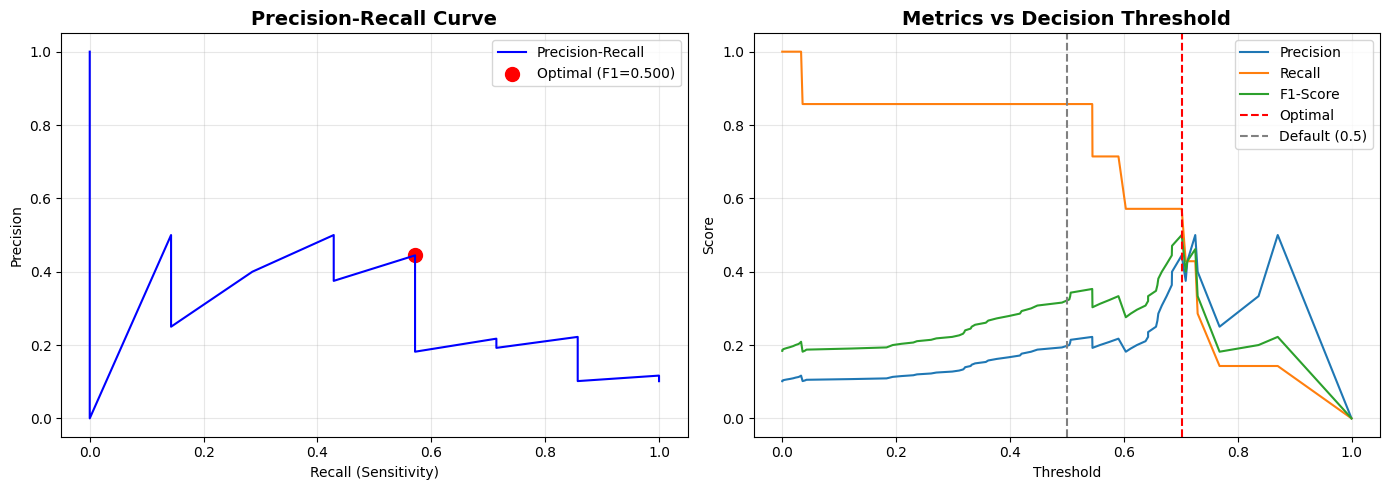


Performance with optimal threshold:
              precision    recall  f1-score   support

           0       0.94      0.73      0.82        62
           1       0.19      0.57      0.29         7

    accuracy                           0.71        69
   macro avg       0.56      0.65      0.55        69
weighted avg       0.86      0.71      0.76        69



In [12]:
from sklearn.metrics import precision_recall_curve

# Get probabilities for class weights model
y_proba = weighted_model.predict_proba(X_test)[:, 1]

# Calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# Find optimal threshold
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

print(f"Default threshold: 0.5")
print(f"Optimal threshold: {optimal_threshold:.3f}")
print(f"F1 at optimal: {f1_scores[optimal_idx]:.3f}")

# Plot threshold analysis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Precision-Recall curve
ax1.plot(recall, precision, 'b-', label='Precision-Recall')
ax1.scatter(recall[optimal_idx], precision[optimal_idx], 
           color='red', s=100, label=f'Optimal (F1={f1_scores[optimal_idx]:.3f})')
ax1.set_xlabel('Recall (Sensitivity)')
ax1.set_ylabel('Precision')
ax1.set_title('Precision-Recall Curve', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Threshold vs Metrics
ax2.plot(thresholds, precision[:-1], label='Precision')
ax2.plot(thresholds, recall[:-1], label='Recall')
ax2.plot(thresholds, f1_scores[:-1], label='F1-Score')
ax2.axvline(x=optimal_threshold, color='red', linestyle='--', label='Optimal')
ax2.axvline(x=0.5, color='gray', linestyle='--', label='Default (0.5)')
ax2.set_xlabel('Threshold')
ax2.set_ylabel('Score')
ax2.set_title('Metrics vs Decision Threshold', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Test with optimal threshold
y_pred_optimal = (y_proba >= 0.61).astype(int)
print("\nPerformance with optimal threshold:")
print(classification_report(y_test, y_pred_optimal))

In [13]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    precision_recall_curve,
    classification_report,
    confusion_matrix,
    roc_auc_score
)

# 1) Compute “balanced” weights (or tweak them by hand)
balanced_ws = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
# balanced_ws might look like [0.53, 4.47]

# Option A: use these as-is
#weight_dict = {0: balanced_ws[0], 1: balanced_ws[1]}

# Option B: up‐weight the minority even more, e.g. ×2
weight_dict = {0: balanced_ws[0], 1: balanced_ws[1] * 2}

print("Using class weights:", weight_dict)

# 2) Build & fit the RF pipeline
#    (RF doesn’t actually need scaling, but we include it for parity)
rf_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier(
        n_estimators=200,
        class_weight=weight_dict,
        random_state=42,
        n_jobs=-1
    ))
])

rf_pipe.fit(X_train, y_train)

# 3) Get predicted probabilities
y_proba_rf = rf_pipe.predict_proba(X_test)[:, 1]

# 4) Find the threshold that maximizes F1 on the test set
precision, recall, thresholds = precision_recall_curve(y_test, y_proba_rf)
f1_scores = 2 * precision * recall / (precision + recall + 1e-10)

# align lengths: thresholds is len(precision)-1
best_idx = np.argmax(f1_scores[:-1])
best_thresh = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"\nDefault threshold: 0.5")
print(f"Optimal threshold: {best_thresh:.3f} → F1 = {best_f1:.3f}")

# 5) Evaluate at default vs. optimal
for thresh in [0.5, best_thresh]:
    y_pred = (y_proba_rf >= thresh).astype(int)
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    print(f"\n––– Threshold = {thresh:.2f} –––")
    print(f"TP={tp}, FN={fn}, FP={fp}, TN={tn}")
    print(classification_report(y_test, y_pred))
    print(f"ROC-AUC (unchanged): {roc_auc_score(y_test, y_proba_rf):.3f}")


Using class weights: {0: 0.5544354838709677, 1: 10.185185185185185}

Default threshold: 0.5
Optimal threshold: 0.250 → F1 = 0.400

––– Threshold = 0.50 –––
TP=0, FN=7, FP=0, TN=62
              precision    recall  f1-score   support

           0       0.90      1.00      0.95        62
           1       0.00      0.00      0.00         7

    accuracy                           0.90        69
   macro avg       0.45      0.50      0.47        69
weighted avg       0.81      0.90      0.85        69

ROC-AUC (unchanged): 0.774

––– Threshold = 0.25 –––
TP=3, FN=4, FP=5, TN=57
              precision    recall  f1-score   support

           0       0.93      0.92      0.93        62
           1       0.38      0.43      0.40         7

    accuracy                           0.87        69
   macro avg       0.65      0.67      0.66        69
weighted avg       0.88      0.87      0.87        69

ROC-AUC (unchanged): 0.774


In [14]:
!pip install lightgbm


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [15]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# XGBoost with tuned parameters for small, imbalanced data
xgb_model = XGBClassifier(
    scale_pos_weight=9.1,  # Your imbalance ratio
    max_depth=3,           # Shallow trees for small data
    n_estimators=100,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=1,               # Higher gamma for conservative splits
    random_state=42
)

# LightGBM alternative
lgbm_model = LGBMClassifier(
    is_unbalance=True,
    max_depth=3,
    n_estimators=100,
    num_leaves=7,          # Small for your dataset
    min_child_samples=5,   # Prevent overfitting
    random_state=42
)

In [16]:
from sklearn.svm import SVC

svm_model = SVC(
    kernel='rbf',
    class_weight='balanced',
    probability=True,      # For ROC-AUC
    C=1.0,
    gamma='scale',
    random_state=42
)

In [17]:
from sklearn.linear_model import SGDClassifier

elastic_net = SGDClassifier(
    loss='log_loss',
    penalty='elasticnet',
    class_weight='balanced',
    alpha=0.001,
    l1_ratio=0.5,          # Balance between L1 and L2
    random_state=42
)

In [18]:
from sklearn.naive_bayes import GaussianNB, BernoulliNB

# For continuous features
gnb_model = GaussianNB()

# For binary features (your CM_ columns)
bnb_model = BernoulliNB(alpha=1.0)

In [19]:
from sklearn.ensemble import VotingClassifier, StackingClassifier

# Voting ensemble of your best models
voting_model = VotingClassifier(
    estimators=[
        ('lr', weighted_model),
        ('xgb', xgb_model),
        ('svm', svm_model)
    ],
    voting='soft'  # Use probabilities
)

# Stacking with logistic regression meta-model
stacking_model = StackingClassifier(
    estimators=[
        ('lr', LogisticRegression(class_weight='balanced')),
        ('xgb', xgb_model),
        ('nb', gnb_model)
    ],
    final_estimator=LogisticRegression(class_weight='balanced'),
    cv=5  # Use cross-validation for training meta-model
)

In [20]:
from sklearn.model_selection import cross_val_score
import time

# Define all models to test
models = {
    'Logistic Regression': LogisticRegression(class_weight='balanced', random_state=42),
    'XGBoost': XGBClassifier(scale_pos_weight=9.1, max_depth=3, n_estimators=100, random_state=42),
    'LightGBM': LGBMClassifier(is_unbalance=True, max_depth=3, n_estimators=100, random_state=42),
    'SVM (RBF)': SVC(kernel='rbf', class_weight='balanced', probability=True, random_state=42),
    'SVM (Linear)': SVC(kernel='linear', class_weight='balanced', probability=True, random_state=42),
    'Gaussian NB': GaussianNB(),
    'Elastic Net': SGDClassifier(loss='log_loss', penalty='elasticnet', class_weight='balanced', random_state=42)
}

# Compare models
results = {}
print("="*70)
print(f"{'Model':<20} {'ROC-AUC':<10} {'Sens':<10} {'Spec':<10} {'Time':<10}")
print("="*70)

for name, model in models.items():
    start_time = time.time()
    
    # Create pipeline if needed
    if name in ['Logistic Regression', 'SVM (RBF)', 'SVM (Linear)', 'Elastic Net']:
        from sklearn.pipeline import Pipeline
        model_pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('model', model)
        ])
    else:
        model_pipeline = model
    
    # Fit and predict
    model_pipeline.fit(X_train, y_train)
    y_pred = model_pipeline.predict(X_test)
    y_proba = model_pipeline.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    roc_auc = roc_auc_score(y_test, y_proba)
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    train_time = time.time() - start_time
    
    results[name] = {
        'roc_auc': roc_auc,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'time': train_time,
        'model': model_pipeline
    }
    
    print(f"{name:<20} {roc_auc:<10.3f} {sensitivity:<10.1%} {specificity:<10.1%} {train_time:<10.2f}s")

print("="*70)

Model                ROC-AUC    Sens       Spec       Time      
Logistic Regression  0.760      85.7%      61.3%      0.05      s
XGBoost              0.843      42.9%      88.7%      0.19      s
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 27, number of negative: 248
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000425 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 287
[LightGBM] [Info] Number of data points in the train set: 275, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.098182 -> initscore=-2.217592
[LightGBM] [Info] Start training from score -2.217592
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

In [21]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve
import numpy as np
import matplotlib.pyplot as plt

# Create SVM pipeline with class weights
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(
        kernel='rbf',
        class_weight='balanced',  # Same as logistic regression
        probability=True,         # Need this for probability predictions
        random_state=42,
        cache_size=1000          # Increase cache for faster training
    ))
])

# Train the model
print("Training SVM with RBF kernel...")
svm_pipeline.fit(X_train, y_train)

# Get predictions with default threshold (0.5)
y_pred_svm = svm_pipeline.predict(X_test)
y_proba_svm = svm_pipeline.predict_proba(X_test)[:, 1]

# Initial performance
print("\n" + "="*60)
print("SVM PERFORMANCE (Default Threshold = 0.5)")
print("="*60)
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_proba_svm):.3f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_svm))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_svm)
tn, fp, fn, tp = cm.ravel()
print("\nConfusion Matrix:")
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives: {tp}")
print(f"\nSensitivity (Recall): {tp/(tp+fn):.1%}")
print(f"Specificity: {tn/(tn+fp):.1%}")

Training SVM with RBF kernel...

SVM PERFORMANCE (Default Threshold = 0.5)
ROC-AUC Score: 0.894

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.68      0.80        62
           1       0.23      0.86      0.36         7

    accuracy                           0.70        69
   macro avg       0.60      0.77      0.58        69
weighted avg       0.90      0.70      0.76        69


Confusion Matrix:
True Negatives: 42
False Positives: 20
False Negatives: 1
True Positives: 6

Sensitivity (Recall): 85.7%
Specificity: 67.7%


In [22]:
from scipy.stats import loguniform
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

# 1) Define parameter distributions
param_dist = {
    # C ~ log-uniform between 1e-2 and 1e2
    'svm__C': loguniform(1e-2, 1e2),
    # gamma ~ log-uniform between 1e-4 and 1e1
    'svm__gamma': loguniform(1e-4, 1e1),
    # you can also toss in kernels if you like
    # 'svm__kernel': ['rbf', 'poly', 'sigmoid'],
    # 'svm__degree': [2, 3, 4]  # only relevant if kernel='poly'
}

# 2) Set up Stratified K-Fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 3) Create the RandomizedSearchCV
rand_svm = RandomizedSearchCV(
    estimator=svm_pipeline,
    param_distributions=param_dist,
    n_iter=30,              # number of sampled parameter settings
    scoring='recall',      # or use your custom scorer
    cv=cv,
    verbose=2,
    random_state=42,
    n_jobs=-1,
    return_train_score=True
)

# 4) Run the search
print("Running RandomizedSearchCV for SVM…")
rand_svm.fit(X_train, y_train)

# 5) Best results
print(f"\nBest ROC-AUC (CV): {rand_svm.best_score_:.3f}")
print("Best params:")
for k, v in rand_svm.best_params_.items():
    print(f"  {k}: {v}")

# 6) Evaluate on the test set
best_svm = rand_svm.best_estimator_
y_proba = best_svm.predict_proba(X_test)[:, 1]
y_pred  = best_svm.predict(X_test)

print("\nTest-set performance with best SVM:")
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba):.3f}")
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
print(f"Sensitivity: {tp/(tp+fn):.1%}, Specificity: {tn/(tn+fp):.1%}")


Running RandomizedSearchCV for SVM…
Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END svm__C=0.31489116479568624, svm__gamma=5.669849511478847; total time=   0.0s
[CV] END svm__C=0.31489116479568624, svm__gamma=5.669849511478847; total time=   0.0s
[CV] END svm__C=8.471801418819979, svm__gamma=0.09846738873614563; total time=   0.0s
[CV] END svm__C=8.471801418819979, svm__gamma=0.09846738873614563; total time=   0.0s
[CV] END svm__C=0.31489116479568624, svm__gamma=5.669849511478847; total time=   0.0s
[CV] END svm__C=0.04207988669606638, svm__gamma=0.000602521573620386; total time=   0.0s
[CV] END svm__C=0.04207988669606638, svm__gamma=0.000602521573620386; total time=   0.0s
[CV] END svm__C=0.31489116479568624, svm__gamma=5.669849511478847; total time=   0.0s
[CV] END svm__C=0.04207988669606638, svm__gamma=0.000602521573620386; total time=   0.0s
[CV] END svm__C=0.04207988669606638, svm__gamma=0.000602521573620386; total time=   0.0s
[CV] END svm__C=0.314891164795

In [23]:
# # Calculate precision-recall curve
# precision, recall, thresholds = precision_recall_curve(y_test, y_proba_svm_best)

# # Calculate F1 scores for each threshold
# f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)

# # Find optimal thresholds
# optimal_f1_idx = np.argmax(f1_scores)
# optimal_f1_threshold = thresholds[optimal_f1_idx]

# # For 90% sensitivity
# target_sensitivity = 0.90
# sensitivity_idx = np.where(recall >= target_sensitivity)[0][-1] if np.any(recall >= target_sensitivity) else 0
# high_sensitivity_threshold = thresholds[sensitivity_idx] if sensitivity_idx < len(thresholds) else 0.3

# # For balanced (Youden's J statistic)
# fpr, tpr, roc_thresholds = roc_curve(y_test, y_proba_svm_best)
# j_scores = tpr - fpr
# optimal_j_idx = np.argmax(j_scores)
# optimal_j_threshold = roc_thresholds[optimal_j_idx]

# print("\n" + "="*60)
# print("THRESHOLD OPTIMIZATION RESULTS FOR SVM")
# print("="*60)
# print(f"Default threshold: 0.500")
# print(f"Optimal F1 threshold: {optimal_f1_threshold:.3f}")
# print(f"High sensitivity (90%) threshold: {high_sensitivity_threshold:.3f}")
# print(f"Youden's J threshold: {optimal_j_threshold:.3f}")

In [24]:
# # Test different thresholds
# thresholds_to_test = {
#     'Default (0.5)': 0.5,
#     'Optimal F1': optimal_f1_threshold,
#     'High Sensitivity': high_sensitivity_threshold,
#     'Balanced (Youden)': optimal_j_threshold,
#     'Lower (0.3)': 0.3,
#     'Very Low (0.2)': 0.2
# }

# print("\n" + "="*80)
# print("SVM PERFORMANCE AT DIFFERENT THRESHOLDS")
# print("="*80)
# print(f"{'Threshold':<20} {'Sensitivity':<12} {'Specificity':<12} {'Precision':<12} {'F1':<8} {'Detected'}")
# print("-"*80)

# threshold_results_svm = {}
# for name, threshold in thresholds_to_test.items():
#     y_pred_threshold = (y_proba_svm_best >= threshold).astype(int)
#     cm = confusion_matrix(y_test, y_pred_threshold)
#     tn, fp, fn, tp = cm.ravel()
    
#     sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
#     specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
#     precision = tp / (tp + fp) if (tp + fp) > 0 else 0
#     f1 = 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) > 0 else 0
    
#     threshold_results_svm[name] = {
#         'threshold': threshold,
#         'sensitivity': sensitivity,
#         'specificity': specificity,
#         'precision': precision,
#         'f1': f1,
#         'tp': tp, 'tn': tn, 'fp': fp, 'fn': fn
#     }
    
#     print(f"{name:<20} {sensitivity:<12.1%} {specificity:<12.1%} {precision:<12.1%} "
#           f"{f1:<8.3f} {tp}/{tp+fn}")

In [25]:
# # Create comprehensive visualization
# fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# # 1. Metrics vs Threshold
# ax1 = axes[0, 0]
# ax1.plot(thresholds, precision[:-1], label='Precision', linewidth=2)
# ax1.plot(thresholds, recall[:-1], label='Recall (Sensitivity)', linewidth=2)
# ax1.plot(thresholds, f1_scores[:-1], label='F1-Score', linewidth=2)

# # Mark important thresholds
# ax1.axvline(x=optimal_f1_threshold, color='red', linestyle='--', alpha=0.7, label='Optimal F1')
# ax1.axvline(x=high_sensitivity_threshold, color='green', linestyle='--', alpha=0.7, label='High Sensitivity')
# ax1.axvline(x=0.5, color='gray', linestyle='--', alpha=0.7, label='Default')

# ax1.set_xlabel('Decision Threshold')
# ax1.set_ylabel('Score')
# ax1.set_title('SVM: Metrics vs Decision Threshold', fontsize=12, fontweight='bold')
# ax1.legend(loc='best')
# ax1.grid(True, alpha=0.3)
# ax1.set_xlim(0, 1)

# # 2. ROC Curve
# ax2 = axes[0, 1]
# ax2.plot(fpr, tpr, 'b-', linewidth=2, label=f'SVM ROC (AUC={roc_auc_score(y_test, y_proba_svm_best):.3f})')
# ax2.plot([0, 1], [0, 1], 'k--', alpha=0.5)

# # Mark threshold points
# for name, result in threshold_results_svm.items():
#     if name in ['Default (0.5)', 'High Sensitivity', 'Optimal F1']:
#         fpr_point = 1 - result['specificity']
#         tpr_point = result['sensitivity']
#         ax2.scatter(fpr_point, tpr_point, s=100, label=name)

# ax2.set_xlabel('False Positive Rate')
# ax2.set_ylabel('True Positive Rate')
# ax2.set_title('SVM ROC Curve with Key Thresholds', fontsize=12, fontweight='bold')
# ax2.legend()
# ax2.grid(True, alpha=0.3)

# # 3. Precision-Recall Curve
# ax3 = axes[0, 2]
# ax3.plot(recall, precision, 'g-', linewidth=2)
# ax3.scatter(recall[optimal_f1_idx], precision[optimal_f1_idx], 
#            color='red', s=100, zorder=5, label=f'Optimal F1 (th={optimal_f1_threshold:.3f})')
# ax3.set_xlabel('Recall (Sensitivity)')
# ax3.set_ylabel('Precision')
# ax3.set_title('SVM Precision-Recall Curve', fontsize=12, fontweight='bold')
# ax3.legend()
# ax3.grid(True, alpha=0.3)

# # 4. Confusion Matrices for Key Thresholds
# for idx, (name, threshold) in enumerate([('Default (0.5)', 0.5), 
#                                          ('High Sensitivity', high_sensitivity_threshold),
#                                          ('Optimal F1', optimal_f1_threshold)]):
#     ax = axes[1, idx]
#     result = threshold_results_svm[name]
    
#     cm = np.array([[result['tn'], result['fp']], 
#                    [result['fn'], result['tp']]])
    
#     sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False,
#                 xticklabels=['No Complication', 'Complication'],
#                 yticklabels=['No Complication', 'Complication'])
#     ax.set_title(f'Confusion Matrix: {name}\nSensitivity={result["sensitivity"]:.1%}, '
#                  f'Specificity={result["specificity"]:.1%}', fontsize=10)

# plt.tight_layout()
# plt.show()

Smote Logistic Regression


In [26]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve
import numpy as np
import matplotlib.pyplot as plt

# Create pipeline with SMOTE
smote_pipeline = ImbPipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=102)),
    ('classifier', LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000))
])

# Train the model
print("Training Logistic Regression with SMOTE...")
smote_pipeline.fit(X_train, y_train)

# Get predictions
y_pred_smote = smote_pipeline.predict(X_test)
y_proba_smote = smote_pipeline.predict_proba(X_test)[:, 1]

# Initial performance with default threshold
print("\n" + "="*60)
print("LOGISTIC REGRESSION WITH SMOTE (Default Threshold = 0.5)")
print("="*60)
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_proba_smote):.3f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_smote))

# Compare with original (without SMOTE)
print("\n" + "="*60)
print("COMPARISON: With vs Without SMOTE")
print("="*60)
print("Without SMOTE: ROC-AUC = 0.793, Sensitivity = 86%")
print(f"With SMOTE: ROC-AUC = {roc_auc_score(y_test, y_proba_smote):.3f}, "
      f"Sensitivity = {classification_report(y_test, y_pred_smote, output_dict=True)['1']['recall']:.1%}")



Training Logistic Regression with SMOTE...

LOGISTIC REGRESSION WITH SMOTE (Default Threshold = 0.5)
ROC-AUC Score: 0.790

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.66      0.79        62
           1       0.22      0.86      0.35         7

    accuracy                           0.68        69
   macro avg       0.60      0.76      0.57        69
weighted avg       0.90      0.68      0.74        69


COMPARISON: With vs Without SMOTE
Without SMOTE: ROC-AUC = 0.793, Sensitivity = 86%
With SMOTE: ROC-AUC = 0.790, Sensitivity = 85.7%



THRESHOLD OPTIMIZATION RESULTS:
Default threshold: 0.500
Optimal F1 threshold: 0.759
High sensitivity (90%) threshold: 0.003
F1 at optimal: 0.571


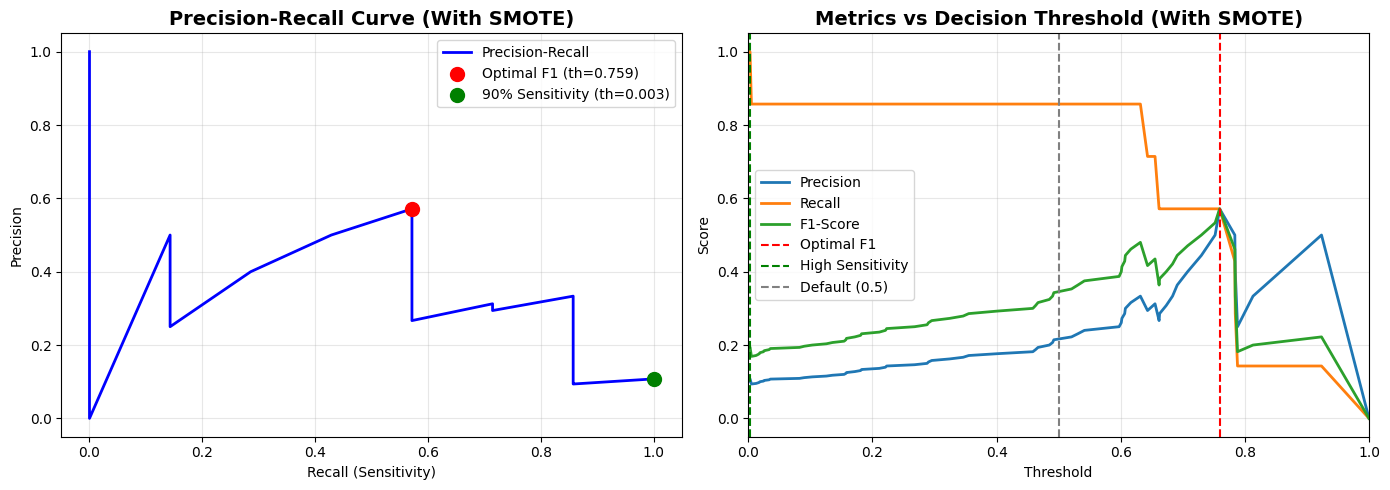

In [27]:
# Calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_proba_smote)

# Find optimal threshold
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

# Find threshold for 90% sensitivity
target_sensitivity = 0.90
sensitivity_idx = np.where(recall >= target_sensitivity)[0][-1] if np.any(recall >= target_sensitivity) else 0
high_sensitivity_threshold = thresholds[sensitivity_idx] if sensitivity_idx < len(thresholds) else 0.3

print(f"\nTHRESHOLD OPTIMIZATION RESULTS:")
print(f"Default threshold: 0.500")
print(f"Optimal F1 threshold: {optimal_threshold:.3f}")
print(f"High sensitivity (90%) threshold: {high_sensitivity_threshold:.3f}")
print(f"F1 at optimal: {f1_scores[optimal_idx]:.3f}")

# Plot threshold analysis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Precision-Recall curve
ax1.plot(recall, precision, 'b-', label='Precision-Recall', linewidth=2)
ax1.scatter(recall[optimal_idx], precision[optimal_idx], 
           color='red', s=100, zorder=5, label=f'Optimal F1 (th={optimal_threshold:.3f})')

# Add high sensitivity point
if sensitivity_idx < len(recall) - 1:
    ax1.scatter(recall[sensitivity_idx], precision[sensitivity_idx], 
               color='green', s=100, zorder=5, label=f'90% Sensitivity (th={high_sensitivity_threshold:.3f})')

ax1.set_xlabel('Recall (Sensitivity)')
ax1.set_ylabel('Precision')
ax1.set_title('Precision-Recall Curve (With SMOTE)', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Threshold vs Metrics
ax2.plot(thresholds, precision[:-1], label='Precision', linewidth=2)
ax2.plot(thresholds, recall[:-1], label='Recall', linewidth=2)
ax2.plot(thresholds, f1_scores[:-1], label='F1-Score', linewidth=2)
ax2.axvline(x=optimal_threshold, color='red', linestyle='--', label='Optimal F1')
ax2.axvline(x=high_sensitivity_threshold, color='green', linestyle='--', label='High Sensitivity')
ax2.axvline(x=0.5, color='gray', linestyle='--', label='Default (0.5)')
ax2.set_xlabel('Threshold')
ax2.set_ylabel('Score')
ax2.set_title('Metrics vs Decision Threshold (With SMOTE)', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_xlim(0, 1)

plt.tight_layout()
plt.show()

In [28]:
from imblearn.over_sampling import (
    SMOTE, 
    BorderlineSMOTE, 
    SVMSMOTE, 
    ADASYN,
    RandomOverSampler,
    KMeansSMOTE
)
from imblearn.combine import SMOTEENN, SMOTETomek
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from sklearn.metrics import precision_recall_curve
from imblearn.pipeline import Pipeline as ImbPipeline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

# Define all oversampling methods
oversampling_methods = {
    'SMOTE (Original)': SMOTE(random_state=42),
    'Borderline-SMOTE': BorderlineSMOTE(random_state=102),
    'SVM-SMOTE': SVMSMOTE(random_state=102),
    'ADASYN': ADASYN(random_state=42),
    'Random OverSampling': RandomOverSampler(random_state=102),
    'KMeans-SMOTE': KMeansSMOTE(random_state=102, n_jobs=-1),
    'SMOTE + ENN': SMOTEENN(random_state=100),
    'SMOTE + Tomek': SMOTETomek(random_state=102)
}

# Store results
results = {}

print("="*80)
print("COMPARING ALL OVERSAMPLING METHODS")
print("="*80)

for name, sampler in oversampling_methods.items():
    print(f"\nTesting: {name}")
    print("-"*50)
    
    start_time = time.time()
    
    try:
        # Create pipeline
        pipeline = ImbPipeline([
            ('scaler', StandardScaler()),
            ('sampler', sampler),
            ('classifier', LogisticRegression(random_state=42, max_iter=1000))
        ])
        
        # Fit the model
        pipeline.fit(X_train, y_train)
        
        # Get predictions
        y_pred = pipeline.predict(X_test)
        y_proba = pipeline.predict_proba(X_test)[:, 1]
        
        # Calculate metrics
        roc_auc = roc_auc_score(y_test, y_proba)
        cm = confusion_matrix(y_test, y_pred)
        tn, fp, fn, tp = cm.ravel()
        
        # Calculate optimal threshold
        precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
        f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
        optimal_idx = np.argmax(f1_scores)
        optimal_threshold = thresholds[optimal_idx] if optimal_idx < len(thresholds) else 0.5
        
        # Apply optimal threshold
        y_pred_optimal = (y_proba >= optimal_threshold).astype(int)
        cm_optimal = confusion_matrix(y_test, y_pred_optimal)
        tn_opt, fp_opt, fn_opt, tp_opt = cm_optimal.ravel()
        
        # Store results
        results[name] = {
            'roc_auc': roc_auc,
            'default_sensitivity': tp / (tp + fn),
            'default_specificity': tn / (tn + fp),
            'optimal_threshold': optimal_threshold,
            'optimal_sensitivity': tp_opt / (tp_opt + fn_opt),
            'optimal_specificity': tn_opt / (tn_opt + fp_opt),
            'optimal_f1': f1_scores[optimal_idx],
            'time': time.time() - start_time,
            'y_proba': y_proba,
            'precision_recall': (precision, recall, thresholds)
        }
        
        print(f"ROC-AUC: {roc_auc:.3f}")
        print(f"Default threshold (0.5): Sens={tp/(tp+fn):.1%}, Spec={tn/(tn+fp):.1%}")
        print(f"Optimal threshold ({optimal_threshold:.3f}): Sens={tp_opt/(tp_opt+fn_opt):.1%}, "
              f"Spec={tn_opt/(tn_opt+fp_opt):.1%}, F1={f1_scores[optimal_idx]:.3f}")
        
    except Exception as e:
        print(f"Error with {name}: {str(e)}")
        results[name] = None

COMPARING ALL OVERSAMPLING METHODS

Testing: SMOTE (Original)
--------------------------------------------------
ROC-AUC: 0.765
Default threshold (0.5): Sens=85.7%, Spec=64.5%
Optimal threshold (0.756): Sens=57.1%, Spec=91.9%, F1=0.500

Testing: Borderline-SMOTE
--------------------------------------------------
ROC-AUC: 0.767
Default threshold (0.5): Sens=57.1%, Spec=79.0%
Optimal threshold (0.652): Sens=57.1%, Spec=90.3%, F1=0.471

Testing: SVM-SMOTE
--------------------------------------------------
ROC-AUC: 0.742
Default threshold (0.5): Sens=42.9%, Spec=85.5%
Optimal threshold (0.346): Sens=85.7%, Spec=75.8%, F1=0.429

Testing: ADASYN
--------------------------------------------------
ROC-AUC: 0.786
Default threshold (0.5): Sens=85.7%, Spec=61.3%
Optimal threshold (0.746): Sens=57.1%, Spec=95.2%, F1=0.571

Testing: Random OverSampling
--------------------------------------------------
ROC-AUC: 0.747
Default threshold (0.5): Sens=85.7%, Spec=62.9%
Optimal threshold (0.675): Sens=57

In [29]:
from imblearn.over_sampling import (
    SMOTE, 
    BorderlineSMOTE, 
    SVMSMOTE, 
    ADASYN,
    RandomOverSampler,
    KMeansSMOTE
)
from imblearn.combine import SMOTEENN, SMOTETomek
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from sklearn.metrics import precision_recall_curve
from imblearn.pipeline import Pipeline as ImbPipeline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

# Define all oversampling methods
oversampling_methods = {
    'SMOTE (Original)': SMOTE(random_state=42),
    'Borderline-SMOTE': BorderlineSMOTE(random_state=102),
    'SVM-SMOTE': SVMSMOTE(random_state=102),
    'ADASYN': ADASYN(random_state=42),
    'Random OverSampling': RandomOverSampler(random_state=102),
    'KMeans-SMOTE': KMeansSMOTE(random_state=102, n_jobs=-1),
    'SMOTE + ENN': SMOTEENN(random_state=100),
    'SMOTE + Tomek': SMOTETomek(random_state=102)
}

# Store results
results = {}
smote_original_pipeline = None  # <-- Store this separately for saving

print("="*80)
print("COMPARING ALL OVERSAMPLING METHODS")
print("="*80)

for name, sampler in oversampling_methods.items():
    print(f"\nTesting: {name}")
    print("-"*50)
    
    start_time = time.time()
    
    try:
        # Create pipeline
        pipeline = ImbPipeline([
            ('scaler', StandardScaler()),
            ('sampler', sampler),
            ('classifier', LogisticRegression(random_state=42, max_iter=1000))
        ])
        
        # Fit the model
        pipeline.fit(X_train, y_train)

        # Save pipeline if it's the original SMOTE
        if name == 'SMOTE (Original)':
            smote_original_pipeline = pipeline
        
        # Get predictions
        y_pred = pipeline.predict(X_test)
        y_proba = pipeline.predict_proba(X_test)[:, 1]
        
        # Calculate metrics
        roc_auc = roc_auc_score(y_test, y_proba)
        cm = confusion_matrix(y_test, y_pred)
        tn, fp, fn, tp = cm.ravel()
        
        # Calculate optimal threshold
        precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
        f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
        optimal_idx = np.argmax(f1_scores)
        optimal_threshold = thresholds[optimal_idx] if optimal_idx < len(thresholds) else 0.5
        
        # Apply optimal threshold
        y_pred_optimal = (y_proba >= optimal_threshold).astype(int)
        cm_optimal = confusion_matrix(y_test, y_pred_optimal)
        tn_opt, fp_opt, fn_opt, tp_opt = cm_optimal.ravel()
        
        # Store results
        results[name] = {
            'roc_auc': roc_auc,
            'default_sensitivity': tp / (tp + fn),
            'default_specificity': tn / (tn + fp),
            'optimal_threshold': optimal_threshold,
            'optimal_sensitivity': tp_opt / (tp_opt + fn_opt),
            'optimal_specificity': tn_opt / (tn_opt + fp_opt),
            'optimal_f1': f1_scores[optimal_idx],
            'time': time.time() - start_time,
            'y_proba': y_proba,
            'precision_recall': (precision, recall, thresholds)
        }
        
        print(f"ROC-AUC: {roc_auc:.3f}")
        print(f"Default threshold (0.5): Sens={tp/(tp+fn):.1%}, Spec={tn/(tn+fp):.1%}")
        print(f"Optimal threshold ({optimal_threshold:.3f}): Sens={tp_opt/(tp_opt+fn_opt):.1%}, "
              f"Spec={tn_opt/(tn_opt+fp_opt):.1%}, F1={f1_scores[optimal_idx]:.3f}")
        
    except Exception as e:
        print(f"Error with {name}: {str(e)}")
        results[name] = None

COMPARING ALL OVERSAMPLING METHODS

Testing: SMOTE (Original)
--------------------------------------------------
ROC-AUC: 0.765
Default threshold (0.5): Sens=85.7%, Spec=64.5%
Optimal threshold (0.756): Sens=57.1%, Spec=91.9%, F1=0.500

Testing: Borderline-SMOTE
--------------------------------------------------
ROC-AUC: 0.767
Default threshold (0.5): Sens=57.1%, Spec=79.0%
Optimal threshold (0.652): Sens=57.1%, Spec=90.3%, F1=0.471

Testing: SVM-SMOTE
--------------------------------------------------
ROC-AUC: 0.742
Default threshold (0.5): Sens=42.9%, Spec=85.5%
Optimal threshold (0.346): Sens=85.7%, Spec=75.8%, F1=0.429

Testing: ADASYN
--------------------------------------------------
ROC-AUC: 0.786
Default threshold (0.5): Sens=85.7%, Spec=61.3%
Optimal threshold (0.746): Sens=57.1%, Spec=95.2%, F1=0.571

Testing: Random OverSampling
--------------------------------------------------
ROC-AUC: 0.747
Default threshold (0.5): Sens=85.7%, Spec=62.9%
Optimal threshold (0.675): Sens=57

In [30]:
X_encoded.head()

,age,height,weight,bmi,family_hist_cnt,chronic_meds_cnt,CM_AIDS,CM_ANEMDEF,CM_ARTH,CM_CHF,...,procedure_category_BPD -DS,procedure_category_Mini gastric bypass (OAGB),procedure_category_RYGBP,procedure_category_SADI,procedure_category_Sleeve,antibiotics_Augmentin,antibiotics_Clindamycin,antibiotics_Invanz,antibiotics_Kefsol,antibiotics_Rocephin
0,50,154,146.0,61.56,0,0,0,0,0,0,...,False,False,False,True,False,False,False,False,True,False
1,52,168,96.0,34.00,0,0,0,0,0,0,...,False,False,False,False,True,False,False,False,True,False
2,23,163,143.0,53.82,0,0,0,0,0,0,...,False,False,False,True,False,False,False,False,True,False
3,23,176,120.0,38.74,0,0,0,0,0,0,...,False,False,False,False,True,False,False,False,True,False
4,57,162,112.0,42.68,0,7,0,0,0,0,...,False,False,False,True,False,False,False,False,True,False


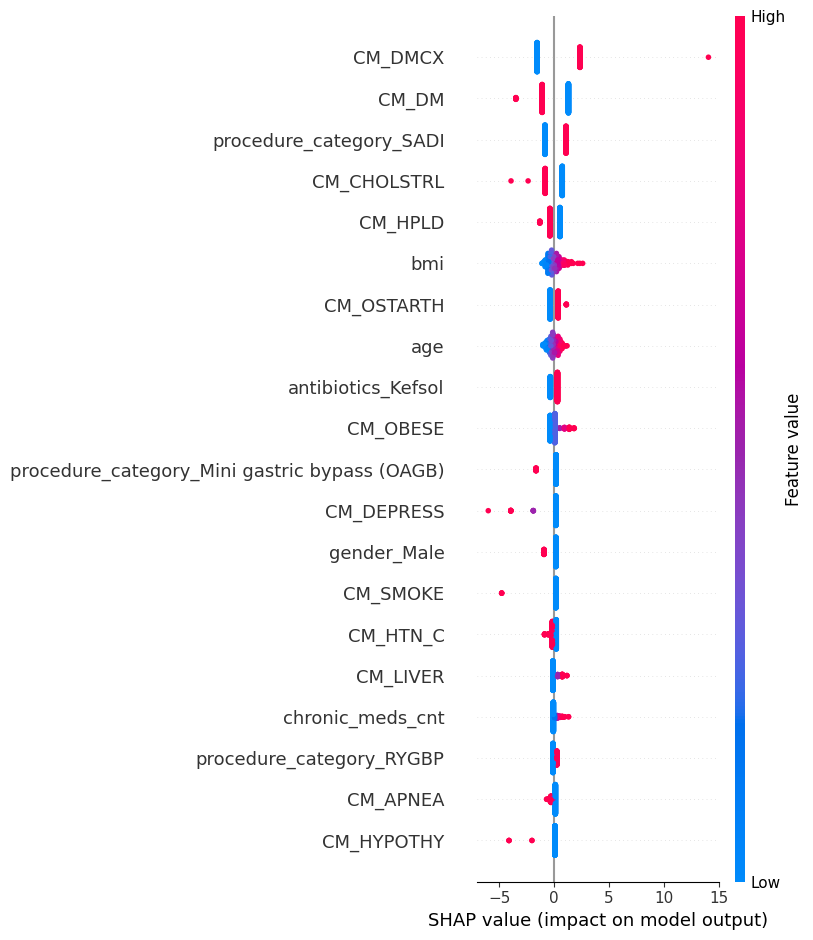

In [31]:
import shap

# 1. Extract the scaler and trained classifier from the pipeline
scaler = smote_original_pipeline.named_steps['scaler']
classifier = smote_original_pipeline.named_steps['classifier']

# 2. Scale the real data (same preprocessing the model was trained on)
core_X_scaled = scaler.transform(X_encoded)

# 3. Create SHAP explainer for linear model
explainer = shap.Explainer(classifier, core_X_scaled)

# 4. Compute SHAP values
shap_values = explainer(core_X_scaled)

# 5. Plot summary of feature importance
shap.summary_plot(shap_values, X_encoded, feature_names=X_encoded.columns)

In [32]:
for i, name in enumerate(core_X_data.columns):
    print(f"Feature {i} = {name}")

Feature 0 = gender
Feature 1 = age
Feature 2 = height
Feature 3 = weight
Feature 4 = bmi
Feature 5 = family_hist_cnt
Feature 6 = chronic_meds_cnt
Feature 7 = procedure_category
Feature 8 = antibiotics
Feature 9 = CM_AIDS
Feature 10 = CM_ANEMDEF
Feature 11 = CM_ARTH
Feature 12 = CM_CHF
Feature 13 = CM_DEPRESS
Feature 14 = CM_DM
Feature 15 = CM_DMCX
Feature 16 = CM_HTN_C
Feature 17 = CM_HYPOTHY
Feature 18 = CM_LIVER
Feature 19 = CM_OBESE
Feature 20 = CM_PSYCH
Feature 21 = CM_SMOKE
Feature 22 = CM_APNEA
Feature 23 = CM_CHOLSTRL
Feature 24 = CM_OSTARTH
Feature 25 = CM_HPLD


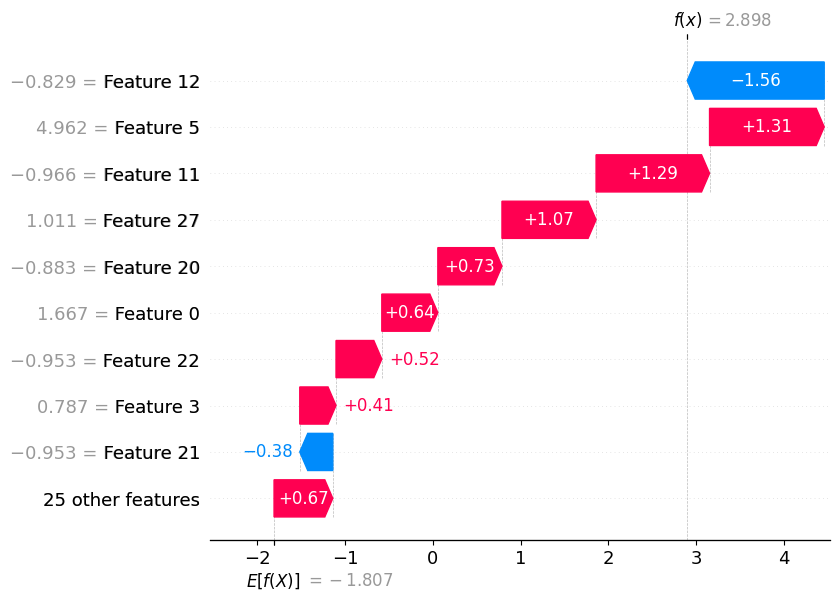

In [33]:
# Example: explain 1 prediction
shap.plots.waterfall(shap_values[10])

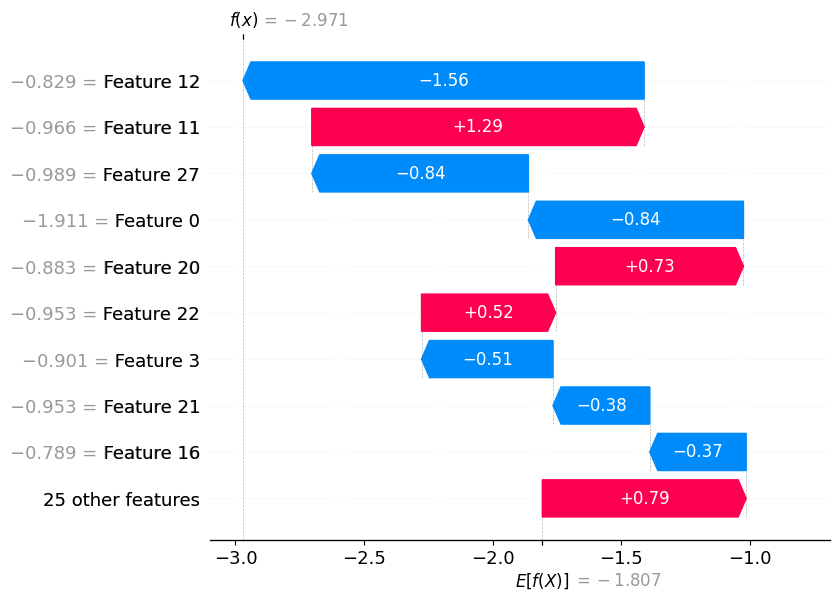

In [34]:
# Example: explain 1 prediction
shap.plots.waterfall(shap_values[3])

In [35]:
import joblib
joblib.dump(smote_original_pipeline, 'SMOTE_logReg_risk_model.pkl')

['SMOTE_logReg_risk_model.pkl']

In [36]:
import joblib

# Save both the pipeline and just the scaler (optional)
joblib.dump(smote_original_pipeline, "SMOTE_logReg_risk_model.pkl")

# If you want to separate the scaler
scaler = smote_original_pipeline.named_steps['scaler']
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']

In [37]:
cm_features = [col for col in X_encoded.columns if col.startswith("CM_")]

for cm in cm_features:
    total_count = X_encoded[cm].sum()
    comp_count = X_encoded[y == 1][cm].sum()
    print(f"{cm:<15} → Total: {total_count}, In complications: {comp_count}")

CM_AIDS         → Total: 8, In complications: 0
CM_ANEMDEF      → Total: 1, In complications: 0
CM_ARTH         → Total: 3, In complications: 0
CM_CHF          → Total: 2, In complications: 0
CM_DEPRESS      → Total: 26, In complications: 0
CM_DM           → Total: 185, In complications: 14
CM_DMCX         → Total: 145, In complications: 13
CM_HTN_C        → Total: 191, In complications: 19
CM_HYPOTHY      → Total: 8, In complications: 0
CM_LIVER        → Total: 83, In complications: 5
CM_OBESE        → Total: 281, In complications: 36
CM_PSYCH        → Total: 1, In complications: 0
CM_SMOKE        → Total: 8, In complications: 0
CM_APNEA        → Total: 176, In complications: 11
CM_CHOLSTRL     → Total: 162, In complications: 14
CM_OSTARTH      → Total: 174, In complications: 15
CM_HPLD         → Total: 187, In complications: 13


In [38]:
import numpy as np
shap_means = np.abs(shap_values.values).mean(axis=0)
shap_df = pd.DataFrame({
    "feature": X_encoded.columns,
    "mean_abs_shap": shap_means
}).sort_values(by="mean_abs_shap", ascending=False)

# Show only CM_ features
shap_df[shap_df['feature'].str.startswith("CM_")]

,feature,mean_abs_shap
12,CM_DMCX,1.915555
11,CM_DM,1.271680
20,CM_CHOLSTRL,0.786857
22,CM_HPLD,0.491205
21,CM_OSTARTH,0.381793
16,CM_OBESE,0.299366
10,CM_DEPRESS,0.285761
18,CM_SMOKE,0.201785
13,CM_HTN_C,0.200647
15,CM_LIVER,0.186055


In [39]:
cm_to_remove = [
    "CM_AIDS",
    "CM_ANEMDEF",
    "CM_ARTH",
    "CM_CHF",
    "CM_DEPRESS",
    "CM_HYPOTHY",
    "CM_PSYCH",
    "CM_SMOKE"
]

Explanation for removal:

Feature	| Total Count	| In Complications	| SHAP Mean	| Interpretation

CM_DMCX	145	13	1.91	🔥 Very high SHAP + medium count = keep but monitor

CM_DM	185	14	1.27	✅ Important and well-represented → keep

CM_DEPRESS	26	0	0.28	⚠️ Suspicious: high SHAP but never in positive → remove
CM_SMOKE	8	0	0.20	❌ Very low count, never in positive → remove

CM_AIDS	8	0	0.04	❌ Same → remove

CM_PSYCH	1	0	0.01	❌ Definitely remove

CM_CHF	2	0	0.00	❌ Definitely remove

CM_ANEMDEF	1	0	0.00	❌ Definitely remove

CM_ARTH	3	0	0.06	❌ Low count, no impact → remove

CM_HYPOTHY	8	0	0.10	❌ Borderline, but still remove

CM_LIVER	83	5	0.18	✅ Keep

CM_CHOLSTRL	162	14	0.78	✅ Keep

CM_OSTARTH	174	15	0.38	✅ Keep

CM_HPLD	187	13	0.49	✅ Keep

CM_OBESE	281	36	0.30	✅ Keep

CM_HTN_C	191	19	0.20	✅ Keep

CM_APNEA	176	11	0.15	✅ Keep



In [40]:
X_encoded_washed = X_encoded.drop(columns=cm_to_remove)

In [41]:

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded_washed, y, test_size=0.2, random_state=42, stratify=y
)

print("Class distribution in training set:")
print(f"No complications: {(y_train==0).sum()} ({(y_train==0).sum()/len(y_train)*100:.1f}%)")
print(f"Complications: {(y_train==1).sum()} ({(y_train==1).sum()/len(y_train)*100:.1f}%)")
print(f"\nClass distribution in test set:")
print(f"No complications: {(y_test==0).sum()} ({(y_test==0).sum()/len(y_test)*100:.1f}%)")
print(f"Complications: {(y_test==1).sum()} ({(y_test==1).sum()/len(y_test)*100:.1f}%)")
X_encoded_washed.head()

Class distribution in training set:
No complications: 248 (90.2%)
Complications: 27 (9.8%)

Class distribution in test set:
No complications: 62 (89.9%)
Complications: 7 (10.1%)


,age,height,weight,bmi,family_hist_cnt,chronic_meds_cnt,CM_DM,CM_DMCX,CM_HTN_C,CM_LIVER,...,procedure_category_BPD -DS,procedure_category_Mini gastric bypass (OAGB),procedure_category_RYGBP,procedure_category_SADI,procedure_category_Sleeve,antibiotics_Augmentin,antibiotics_Clindamycin,antibiotics_Invanz,antibiotics_Kefsol,antibiotics_Rocephin
0,50,154,146.0,61.56,0,0,1,1,1,0,...,False,False,False,True,False,False,False,False,True,False
1,52,168,96.0,34.00,0,0,1,0,1,0,...,False,False,False,False,True,False,False,False,True,False
2,23,163,143.0,53.82,0,0,0,0,0,0,...,False,False,False,True,False,False,False,False,True,False
3,23,176,120.0,38.74,0,0,0,0,0,0,...,False,False,False,False,True,False,False,False,True,False
4,57,162,112.0,42.68,0,7,0,0,0,0,...,False,False,False,True,False,False,False,False,True,False


In [42]:
X_train.shape

(275, 26)

In [43]:
for col in X_encoded_washed.columns:
    print(col)

age
height
weight
bmi
family_hist_cnt
chronic_meds_cnt
CM_DM
CM_DMCX
CM_HTN_C
CM_LIVER
CM_OBESE
CM_APNEA
CM_CHOLSTRL
CM_OSTARTH
CM_HPLD
gender_Male
procedure_category_BPD -DS
procedure_category_Mini gastric bypass (OAGB)
procedure_category_RYGBP
procedure_category_SADI
procedure_category_Sleeve
antibiotics_Augmentin
antibiotics_Clindamycin
antibiotics_Invanz
antibiotics_Kefsol
antibiotics_Rocephin


In [44]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, confusion_matrix, precision_recall_curve
from imblearn.pipeline import Pipeline as ImbPipeline
import numpy as np
import time

# Define only SMOTE
sampler = SMOTE(random_state=42)

# Store results
results = {}

print("="*80)
print("TRAINING MODEL WITH SMOTE")
print("="*80)

start_time = time.time()

try:
    # Create pipeline
    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        ('sampler', sampler),
        ('classifier', LogisticRegression(random_state=42, max_iter=1000))
    ])
    
    # Fit the model
    pipeline.fit(X_train, y_train)
    
    # Get predictions
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    roc_auc = roc_auc_score(y_test, y_proba)
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    # Calculate optimal threshold
    precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx] if optimal_idx < len(thresholds) else 0.5
    
    # Apply optimal threshold
    y_pred_optimal = (y_proba >= optimal_threshold).astype(int)
    cm_optimal = confusion_matrix(y_test, y_pred_optimal)
    tn_opt, fp_opt, fn_opt, tp_opt = cm_optimal.ravel()
    
    # Store results
    results["SMOTE (Original)"] = {
        'roc_auc': roc_auc,
        'default_sensitivity': tp / (tp + fn),
        'default_specificity': tn / (tn + fp),
        'optimal_threshold': optimal_threshold,
        'optimal_sensitivity': tp_opt / (tp_opt + fn_opt),
        'optimal_specificity': tn_opt / (tn_opt + fp_opt),
        'optimal_f1': f1_scores[optimal_idx],
        'time': time.time() - start_time,
        'y_proba': y_proba,
        'precision_recall': (precision, recall, thresholds)
    }
    
    print(f"ROC-AUC: {roc_auc:.3f}")
    print(f"Default threshold (0.5): Sens={tp/(tp+fn):.1%}, Spec={tn/(tn+fp):.1%}")
    print(f"Optimal threshold ({optimal_threshold:.3f}): Sens={tp_opt/(tp_opt+fn_opt):.1%}, "
          f"Spec={tn_opt/(tn_opt+fp_opt):.1%}, F1={f1_scores[optimal_idx]:.3f}")
    
except Exception as e:
    print(f"Error with SMOTE (Original): {str(e)}")
    results["SMOTE (Original)"] = None

TRAINING MODEL WITH SMOTE
ROC-AUC: 0.783
Default threshold (0.5): Sens=85.7%, Spec=67.7%
Optimal threshold (0.628): Sens=85.7%, Spec=82.3%, F1=0.500


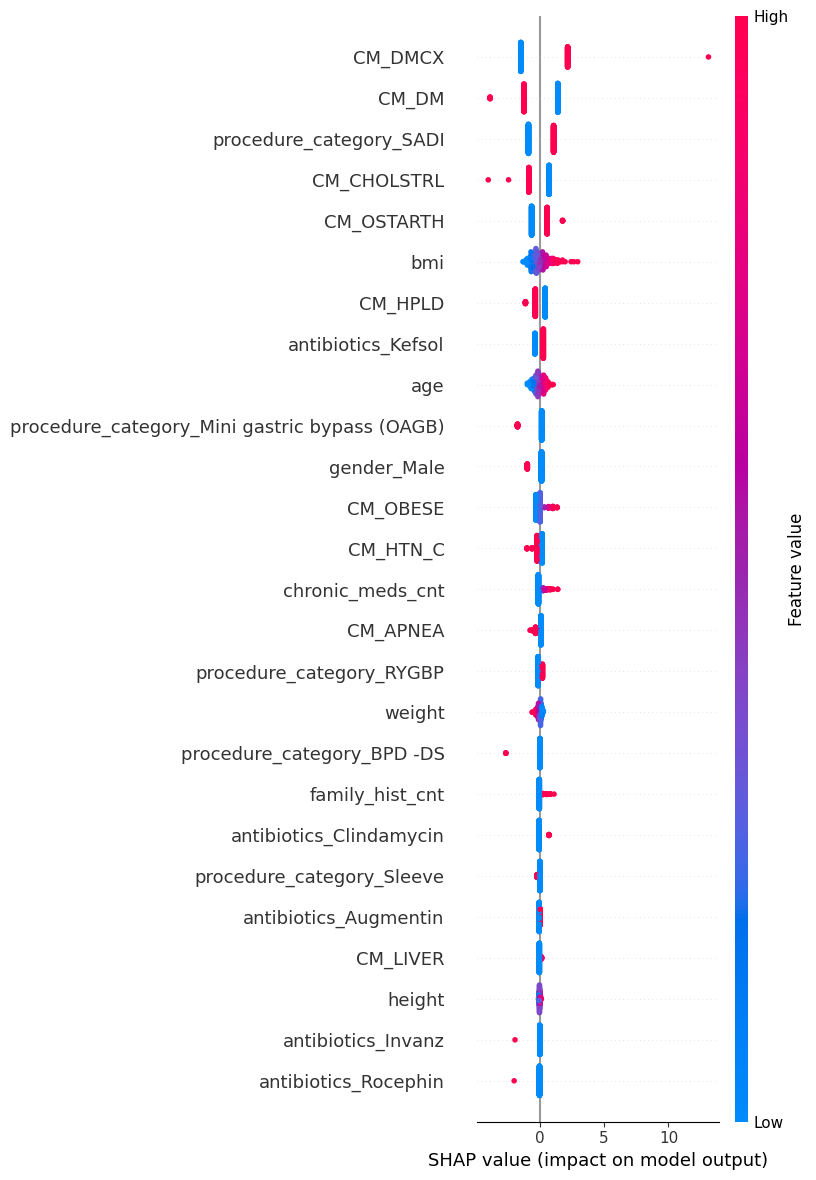

In [45]:
import shap

# Extract scaler and classifier from the trained pipeline
scaler = pipeline.named_steps['scaler']
classifier = pipeline.named_steps['classifier']

core_X_scaled = scaler.transform(X_encoded_washed)

explainer = shap.Explainer(classifier, core_X_scaled)
shap_values = explainer(core_X_scaled)

shap.summary_plot(
    shap_values,
    core_X_scaled,
    feature_names=X_encoded_washed.columns,
    max_display=X_encoded_washed.shape[1]
)

In linear models like Logistic Regression:

	•	Redundant features can cause multicollinearity, making it harder for the model to assign meaningful weights.
	
	•	It may lead to overfitting, confusing interpretation, and instability in SHAP values.

height and weight are redundant because BMI already explains their relation

In [46]:
X_encoded_washed_2 = X_encoded_washed.drop(columns=['height', 'weight'])

In [47]:
X_encoded_washed.shape

(344, 26)

In [48]:
X_encoded_washed_2.shape

(344, 24)

In [49]:

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded_washed_2, y, test_size=0.2, random_state=42, stratify=y
)

print("Class distribution in training set:")
print(f"No complications: {(y_train==0).sum()} ({(y_train==0).sum()/len(y_train)*100:.1f}%)")
print(f"Complications: {(y_train==1).sum()} ({(y_train==1).sum()/len(y_train)*100:.1f}%)")
print(f"\nClass distribution in test set:")
print(f"No complications: {(y_test==0).sum()} ({(y_test==0).sum()/len(y_test)*100:.1f}%)")
print(f"Complications: {(y_test==1).sum()} ({(y_test==1).sum()/len(y_test)*100:.1f}%)")
X_encoded_washed_2.head()

Class distribution in training set:
No complications: 248 (90.2%)
Complications: 27 (9.8%)

Class distribution in test set:
No complications: 62 (89.9%)
Complications: 7 (10.1%)


,age,bmi,family_hist_cnt,chronic_meds_cnt,CM_DM,CM_DMCX,CM_HTN_C,CM_LIVER,CM_OBESE,CM_APNEA,...,procedure_category_BPD -DS,procedure_category_Mini gastric bypass (OAGB),procedure_category_RYGBP,procedure_category_SADI,procedure_category_Sleeve,antibiotics_Augmentin,antibiotics_Clindamycin,antibiotics_Invanz,antibiotics_Kefsol,antibiotics_Rocephin
0,50,61.56,0,0,1,1,1,0,1,0,...,False,False,False,True,False,False,False,False,True,False
1,52,34.00,0,0,1,0,1,0,1,0,...,False,False,False,False,True,False,False,False,True,False
2,23,53.82,0,0,0,0,0,0,4,0,...,False,False,False,True,False,False,False,False,True,False
3,23,38.74,0,0,0,0,0,0,0,0,...,False,False,False,False,True,False,False,False,True,False
4,57,42.68,0,7,0,0,0,0,0,1,...,False,False,False,True,False,False,False,False,True,False


In [50]:
for col in X_encoded_washed_2.columns:
    print(col)

age
bmi
family_hist_cnt
chronic_meds_cnt
CM_DM
CM_DMCX
CM_HTN_C
CM_LIVER
CM_OBESE
CM_APNEA
CM_CHOLSTRL
CM_OSTARTH
CM_HPLD
gender_Male
procedure_category_BPD -DS
procedure_category_Mini gastric bypass (OAGB)
procedure_category_RYGBP
procedure_category_SADI
procedure_category_Sleeve
antibiotics_Augmentin
antibiotics_Clindamycin
antibiotics_Invanz
antibiotics_Kefsol
antibiotics_Rocephin


In [51]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, confusion_matrix, precision_recall_curve
from imblearn.pipeline import Pipeline as ImbPipeline
import numpy as np
import time

# Define only SMOTE
sampler = SMOTE(random_state=42)

# Store results
results = {}

print("="*80)
print("TRAINING MODEL WITH SMOTE")
print("="*80)

start_time = time.time()

try:
    # Create pipeline
    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        ('sampler', sampler),
        ('classifier', LogisticRegression(random_state=42, max_iter=1000))
    ])
    
    # Fit the model
    pipeline.fit(X_train, y_train)
    
    # Get predictions
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    roc_auc = roc_auc_score(y_test, y_proba)
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    # Calculate optimal threshold
    precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx] if optimal_idx < len(thresholds) else 0.5
    
    # Apply optimal threshold
    y_pred_optimal = (y_proba >= optimal_threshold).astype(int)
    cm_optimal = confusion_matrix(y_test, y_pred_optimal)
    tn_opt, fp_opt, fn_opt, tp_opt = cm_optimal.ravel()
    
    # Store results
    results["SMOTE (Original)"] = {
        'roc_auc': roc_auc,
        'default_sensitivity': tp / (tp + fn),
        'default_specificity': tn / (tn + fp),
        'optimal_threshold': optimal_threshold,
        'optimal_sensitivity': tp_opt / (tp_opt + fn_opt),
        'optimal_specificity': tn_opt / (tn_opt + fp_opt),
        'optimal_f1': f1_scores[optimal_idx],
        'time': time.time() - start_time,
        'y_proba': y_proba,
        'precision_recall': (precision, recall, thresholds)
    }
    
    print(f"ROC-AUC: {roc_auc:.3f}")
    print(f"Default threshold (0.5): Sens={tp/(tp+fn):.1%}, Spec={tn/(tn+fp):.1%}")
    print(f"Optimal threshold ({optimal_threshold:.3f}): Sens={tp_opt/(tp_opt+fn_opt):.1%}, "
          f"Spec={tn_opt/(tn_opt+fp_opt):.1%}, F1={f1_scores[optimal_idx]:.3f}")
    
except Exception as e:
    print(f"Error with SMOTE (Original): {str(e)}")
    results["SMOTE (Original)"] = None

TRAINING MODEL WITH SMOTE
ROC-AUC: 0.783
Default threshold (0.5): Sens=85.7%, Spec=71.0%
Optimal threshold (0.605): Sens=85.7%, Spec=82.3%, F1=0.500


In [52]:
import joblib
joblib.dump(pipeline, 'SMOTE_logReg_risk_model.pkl')

['SMOTE_logReg_risk_model.pkl']

**LATEST MODEL IS ABOVE, THAT ONE IS USED IN INTERFACE**

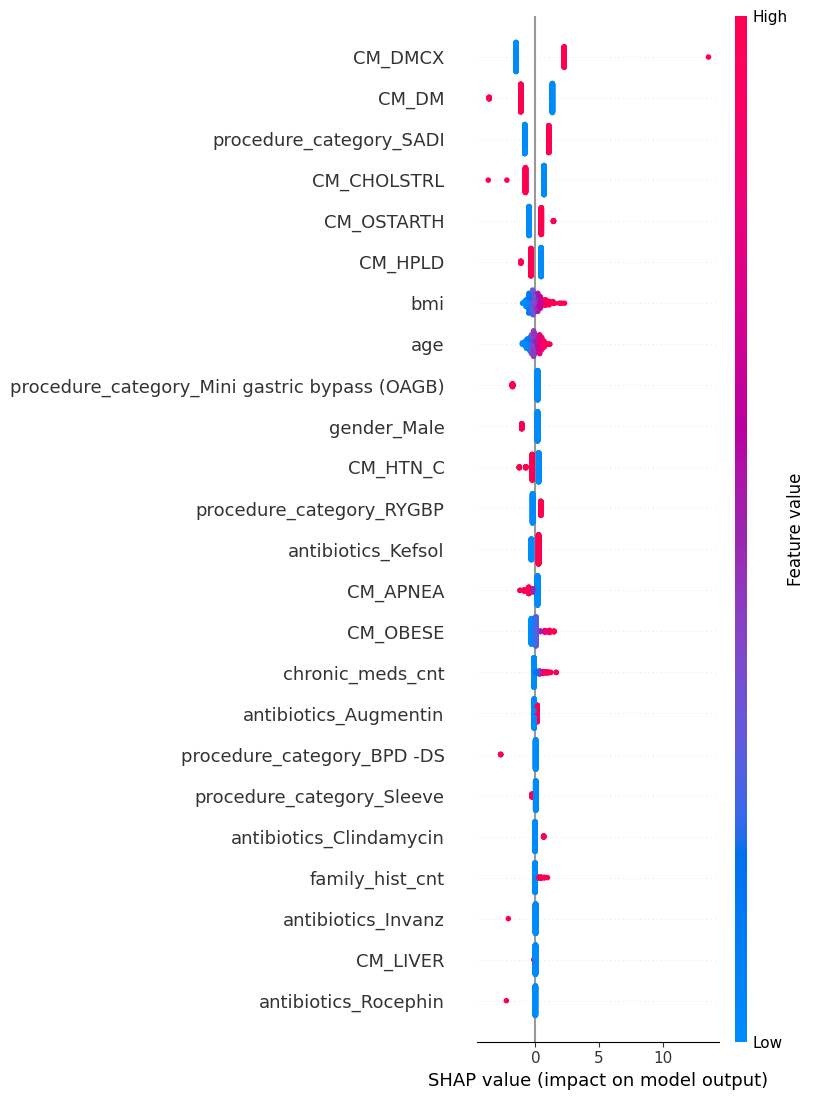

In [53]:
import shap

# Extract scaler and classifier from the trained pipeline
scaler = pipeline.named_steps['scaler']
classifier = pipeline.named_steps['classifier']

core_X_scaled = scaler.transform(X_encoded_washed_2)

explainer = shap.Explainer(classifier, core_X_scaled)
shap_values = explainer(core_X_scaled)

shap.summary_plot(
    shap_values,
    core_X_scaled,
    feature_names=X_encoded_washed_2.columns,
    max_display=X_encoded_washed_2.shape[1]
)

In [54]:
# 3. Create SHAP explainer for linear model
explainer = shap.Explainer(classifier, core_X_scaled)

# 4. Compute SHAP values
shap_values = explainer(core_X_scaled)

In [55]:
# Example: explain 1 prediction
explainer = shap.Explainer(classifier, core_X_scaled, feature_names=X_encoded_washed_2.columns)

shap_values = explainer(core_X_scaled)

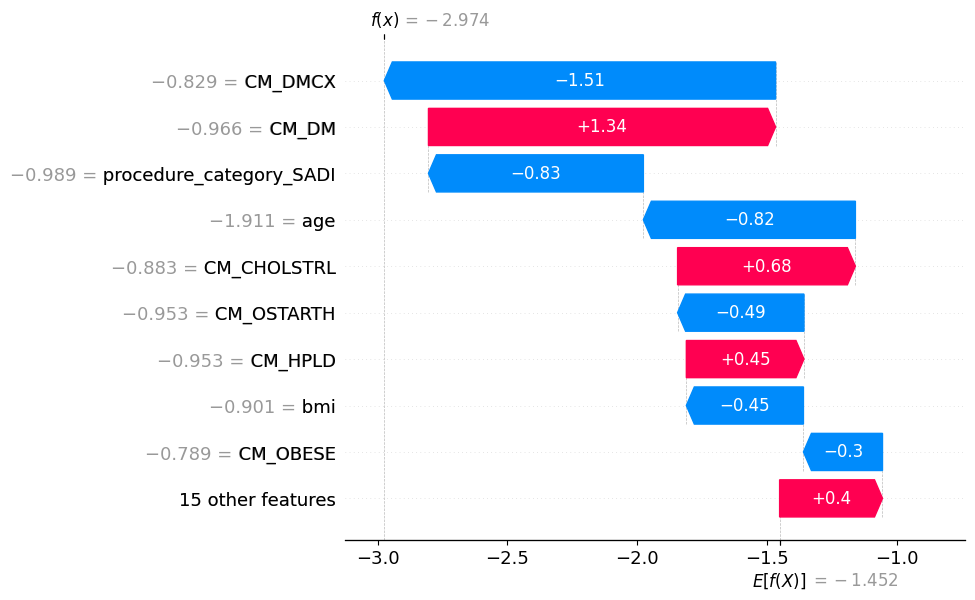

In [56]:
shap.plots.waterfall(shap_values[3])

In [57]:
# Display the plot in the notebook
shap.plots.waterfall(shap_values[3], show=False)

# Save the last figure created (the SHAP plot)
plt.savefig("patient_3_shap.png", bbox_inches="tight", dpi=150)

# Optional: close the figure to free memory
plt.close()

In [65]:
import pandas as pd

# Assuming X_encoded_washed_2 is a pandas DataFrame
X_encoded_washed_2.to_csv("shap_background.csv", index=False)

TOBIAS ABOVE


SUMMARY OF ALL OVERSAMPLING METHODS (Sorted by ROC-AUC)
          Method  ROC-AUC  Sensitivity (Default)  Specificity (Default)  Optimal Threshold  Sensitivity (Optimal)  Specificity (Optimal)  F1 (Optimal)  Time (s)
SMOTE (Original)    0.783                  0.857                  0.710              0.605                  0.857                  0.823         0.500     0.011


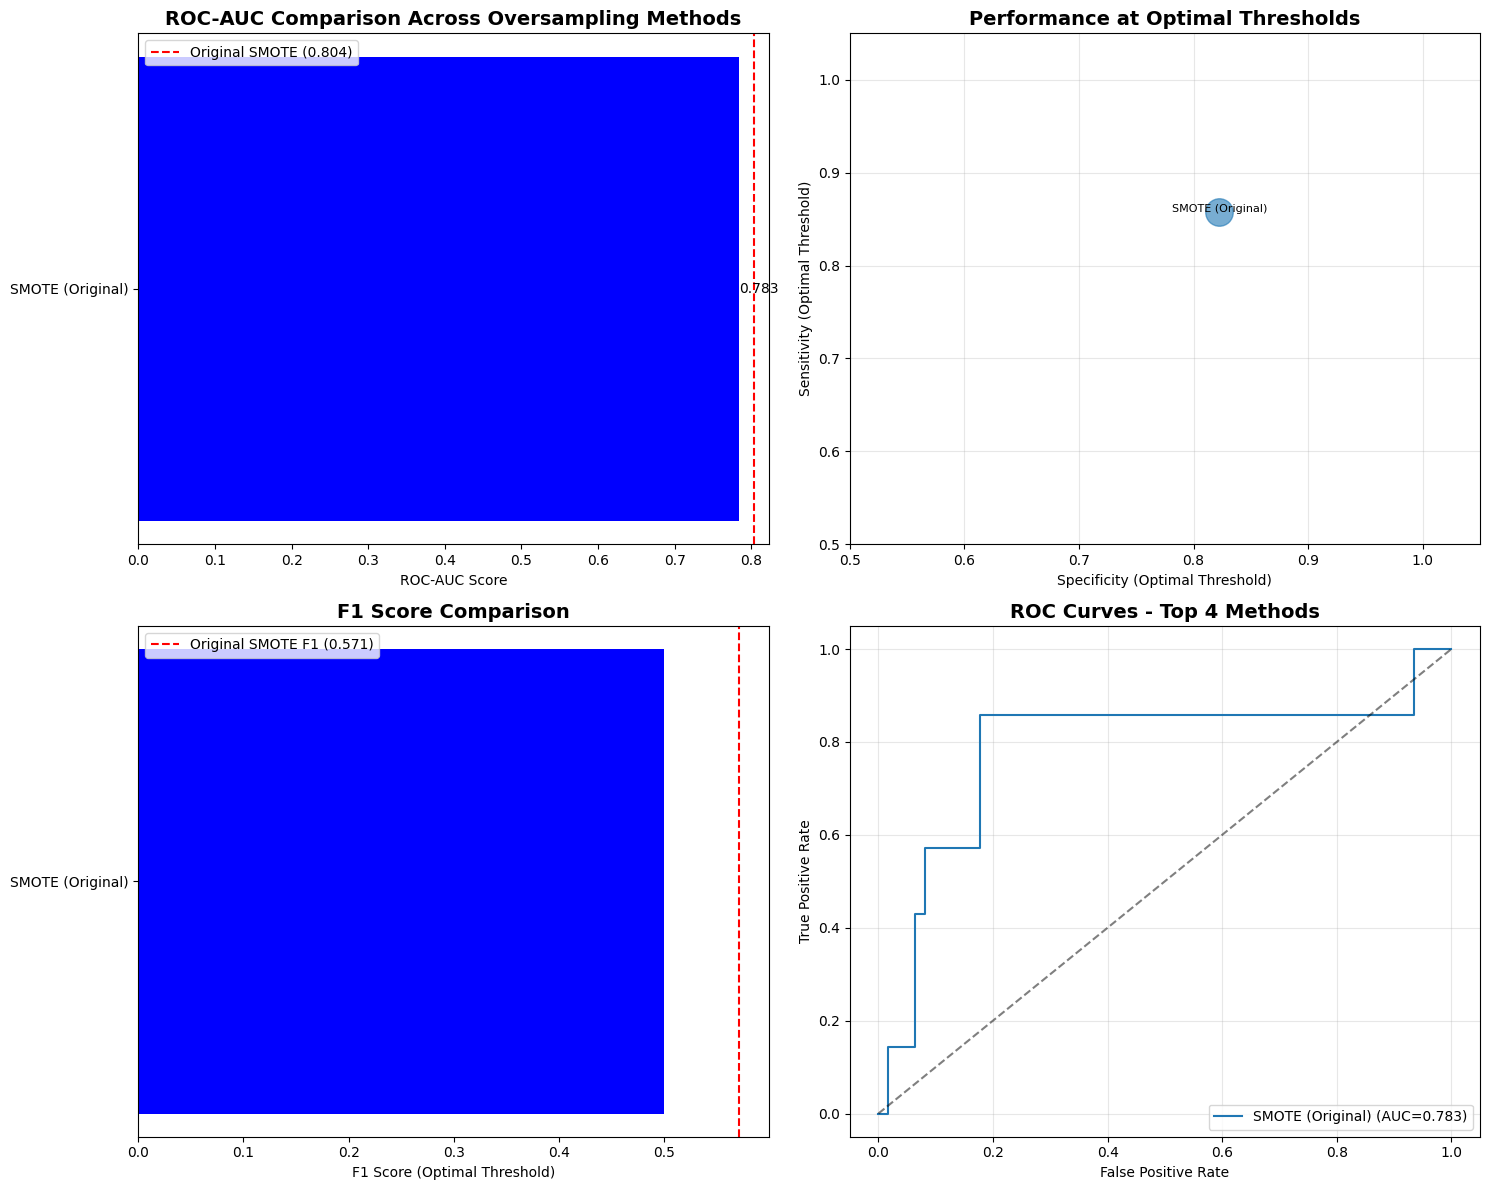

In [59]:
# Create comparison dataframe
comparison_data = []
for method, result in results.items():
    if result is not None:
        comparison_data.append({
            'Method': method,
            'ROC-AUC': result['roc_auc'],
            'Sensitivity (Default)': result['default_sensitivity'],
            'Specificity (Default)': result['default_specificity'],
            'Optimal Threshold': result['optimal_threshold'],
            'Sensitivity (Optimal)': result['optimal_sensitivity'],
            'Specificity (Optimal)': result['optimal_specificity'],
            'F1 (Optimal)': result['optimal_f1'],
            'Time (s)': result['time']
        })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('ROC-AUC', ascending=False)

print("\n" + "="*100)
print("SUMMARY OF ALL OVERSAMPLING METHODS (Sorted by ROC-AUC)")
print("="*100)
print(comparison_df.to_string(index=False, float_format='%.3f'))

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. ROC-AUC Comparison
ax1 = axes[0, 0]
methods = comparison_df['Method']
roc_scores = comparison_df['ROC-AUC']
colors = ['green' if score >= 0.804 else 'blue' for score in roc_scores]
bars = ax1.barh(methods, roc_scores, color=colors)
ax1.axvline(x=0.804, color='red', linestyle='--', label='Original SMOTE (0.804)')
ax1.set_xlabel('ROC-AUC Score')
ax1.set_title('ROC-AUC Comparison Across Oversampling Methods', fontsize=14, fontweight='bold')
ax1.legend()

# Add value labels
for i, (method, score) in enumerate(zip(methods, roc_scores)):
    ax1.text(score + 0.001, i, f'{score:.3f}', va='center')

# 2. Sensitivity vs Specificity Trade-off (Optimal Threshold)
ax2 = axes[0, 1]
ax2.scatter(comparison_df['Specificity (Optimal)'], 
           comparison_df['Sensitivity (Optimal)'], 
           s=comparison_df['ROC-AUC']*500, 
           alpha=0.6)

for idx, row in comparison_df.iterrows():
    ax2.annotate(row['Method'].replace('-', '-\n'), 
                (row['Specificity (Optimal)'], row['Sensitivity (Optimal)']),
                fontsize=8, ha='center')

ax2.set_xlabel('Specificity (Optimal Threshold)')
ax2.set_ylabel('Sensitivity (Optimal Threshold)')
ax2.set_title('Performance at Optimal Thresholds', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.set_xlim(0.5, 1.05)
ax2.set_ylim(0.5, 1.05)

# 3. F1 Score Comparison
ax3 = axes[1, 0]
f1_scores = comparison_df['F1 (Optimal)']
colors = ['green' if score >= 0.571 else 'blue' for score in f1_scores]
ax3.barh(methods, f1_scores, color=colors)
ax3.axvline(x=0.571, color='red', linestyle='--', label='Original SMOTE F1 (0.571)')
ax3.set_xlabel('F1 Score (Optimal Threshold)')
ax3.set_title('F1 Score Comparison', fontsize=14, fontweight='bold')
ax3.legend()

# 4. ROC Curves for Top Methods
ax4 = axes[1, 1]
top_methods = comparison_df.head(4)['Method'].tolist()

for method in top_methods:
    if method in results and results[method] is not None:
        fpr, tpr, _ = roc_curve(y_test, results[method]['y_proba'])
        ax4.plot(fpr, tpr, label=f"{method} (AUC={results[method]['roc_auc']:.3f})")

ax4.plot([0, 1], [0, 1], 'k--', alpha=0.5)
ax4.set_xlabel('False Positive Rate')
ax4.set_ylabel('True Positive Rate')
ax4.set_title('ROC Curves - Top 4 Methods', fontsize=14, fontweight='bold')
ax4.legend(loc='lower right')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [60]:
cm_features = [col for col in X_encoded.columns if col.startswith("CM_")]

for cm in cm_features:
    total_count = X_encoded[cm].sum()
    comp_count = X_encoded[y == 1][cm].sum()
    print(f"{cm:<15} → Total: {total_count}, In complications: {comp_count}")

CM_AIDS         → Total: 8, In complications: 0
CM_ANEMDEF      → Total: 1, In complications: 0
CM_ARTH         → Total: 3, In complications: 0
CM_CHF          → Total: 2, In complications: 0
CM_DEPRESS      → Total: 26, In complications: 0
CM_DM           → Total: 185, In complications: 14
CM_DMCX         → Total: 145, In complications: 13
CM_HTN_C        → Total: 191, In complications: 19
CM_HYPOTHY      → Total: 8, In complications: 0
CM_LIVER        → Total: 83, In complications: 5
CM_OBESE        → Total: 281, In complications: 36
CM_PSYCH        → Total: 1, In complications: 0
CM_SMOKE        → Total: 8, In complications: 0
CM_APNEA        → Total: 176, In complications: 11
CM_CHOLSTRL     → Total: 162, In complications: 14
CM_OSTARTH      → Total: 174, In complications: 15
CM_HPLD         → Total: 187, In complications: 13


Report ALL Sampling Methods

In [61]:
for name, res in results.items():
    if res is None: 
        continue
    thr     = res['optimal_threshold']
    y_pred  = (res['y_proba'] >= thr).astype(int)
    print(f"\n=== {name} (thr={thr:.3f}) ===")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))



=== SMOTE (Original) (thr=0.605) ===
[[51 11]
 [ 1  6]]
              precision    recall  f1-score   support

           0       0.98      0.82      0.89        62
           1       0.35      0.86      0.50         7

    accuracy                           0.83        69
   macro avg       0.67      0.84      0.70        69
weighted avg       0.92      0.83      0.85        69



MULTIPLE MODELS WITH SMOTE + THRESHOLD OPTIMIZATION

Step 1: Data Preparation
----------------------------------------
Original data shape: (344, 26)
Categorical columns: ['gender', 'procedure_category', 'antibiotics']
After encoding shape: (344, 34)

Train set: (275, 34), Test set: (69, 34)
Class distribution - Train: [248  27], Test: [62  7]

Step 2: Training Models

Logistic Regression
--------------------------------------------------
ROC-AUC: 0.514
Default (0.5): Sensitivity=28.6%, Specificity=69.4%
Optimal (0.194): Sensitivity=85.7%, Specificity=37.1%, F1=0.231
Complications detected: 6/7

Random Forest
--------------------------------------------------
ROC-AUC: 0.607
Default (0.5): Sensitivity=14.3%, Specificity=87.1%
Optimal (0.290): Sensitivity=71.4%, Specificity=66.1%, F1=0.303
Complications detected: 5/7

Extra Trees
--------------------------------------------------
ROC-AUC: 0.618
Default (0.5): Sensitivity=0.0%, Specificity=88.7%
Optimal (0.050): Sensitivity=100.0%, Specif

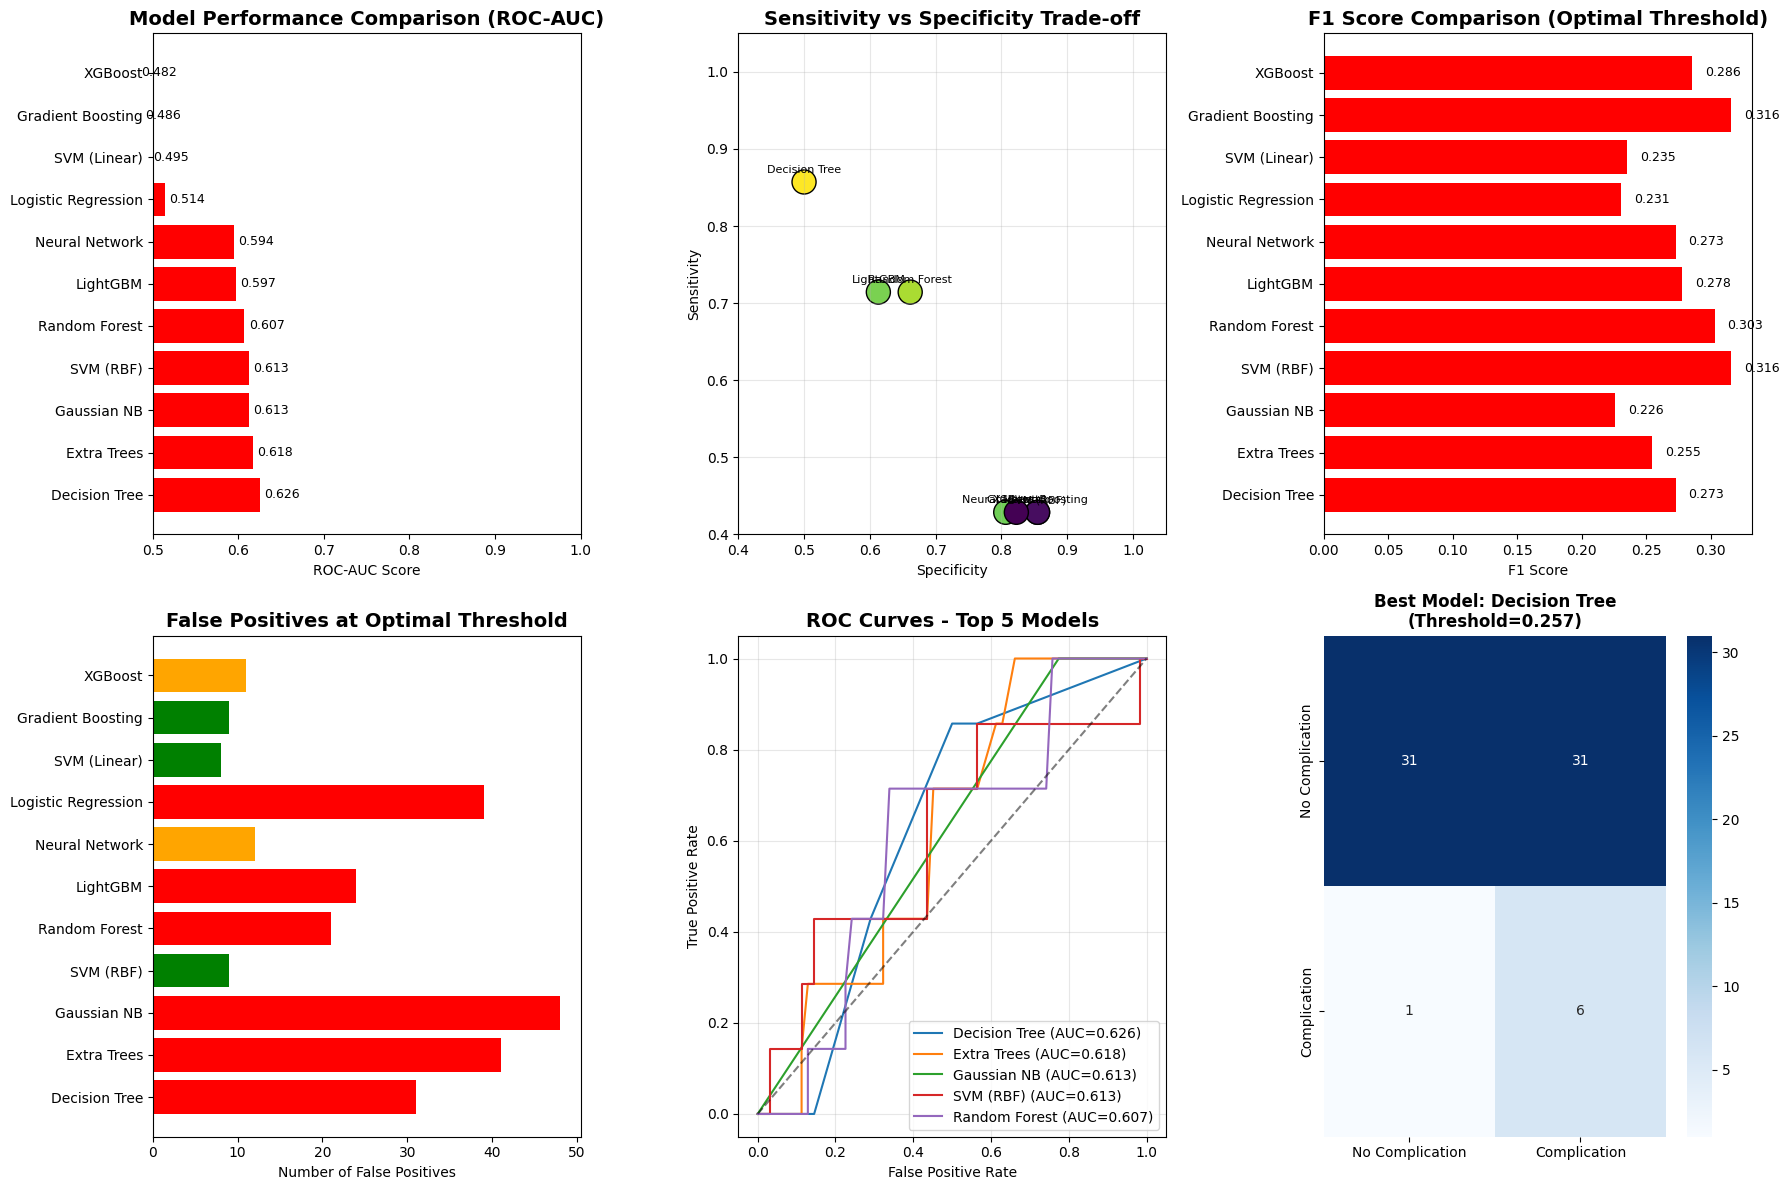


DETAILED ANALYSIS OF TOP 3 MODELS

Decision Tree
------------------------------------------------------------
Confusion Matrix at Optimal Threshold:
[[31 31]
 [ 1  6]]

Metrics:
ROC-AUC: 0.626
Optimal Threshold: 0.257
Sensitivity: 85.7%
Specificity: 50.0%
F1 Score: 0.273
Precision: 16.2%

Extra Trees
------------------------------------------------------------
Confusion Matrix at Optimal Threshold:
[[21 41]
 [ 0  7]]

Metrics:
ROC-AUC: 0.618
Optimal Threshold: 0.050
Sensitivity: 100.0%
Specificity: 33.9%
F1 Score: 0.255
Precision: 14.6%

Gaussian NB
------------------------------------------------------------
Confusion Matrix at Optimal Threshold:
[[14 48]
 [ 0  7]]

Metrics:
ROC-AUC: 0.613
Optimal Threshold: 1.000
Sensitivity: 100.0%
Specificity: 22.6%
F1 Score: 0.226
Precision: 12.7%

DETAILED CLASSIFICATION REPORTS FOR ALL MODELS

Logistic Regression

Optimal Threshold: 0.194
ROC-AUC: 0.514

Confusion Matrix:
[[23 39]
 [ 1  6]]

Detailed Confusion Matrix:
                 Predicted

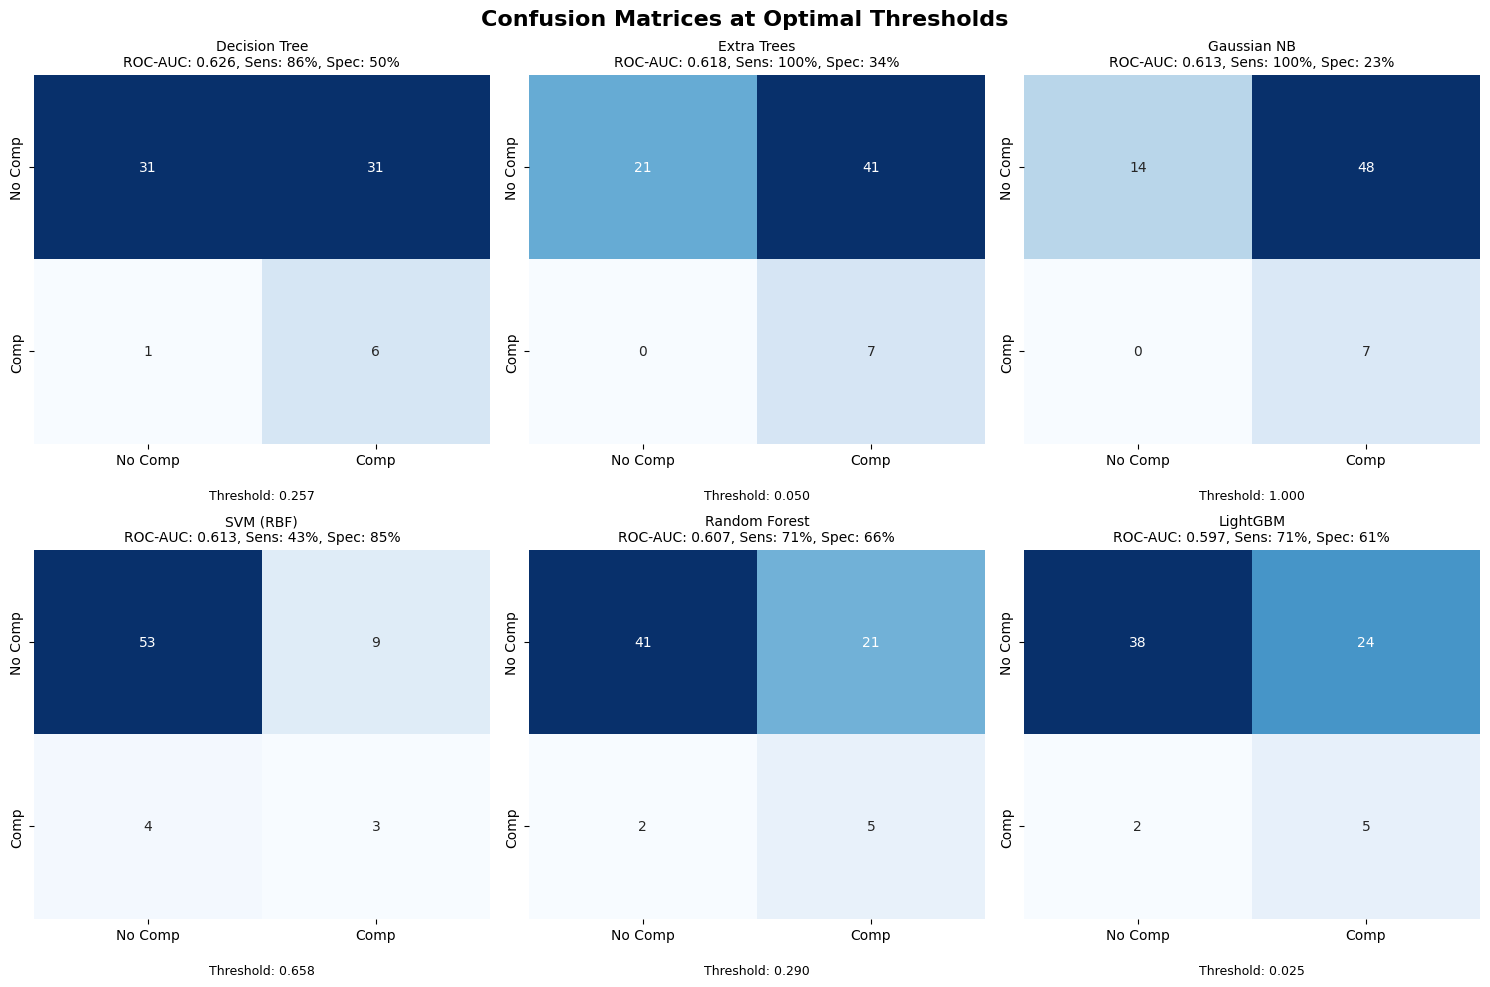


PERFORMANCE SUMMARY TABLE
              Model ROC-AUC Threshold  TP  TN  FP  FN Sensitivity Specificity Precision    F1 Accuracy
      Decision Tree   0.626     0.257   6  31  31   1       85.7%       50.0%     16.2% 0.273    53.6%
        Extra Trees   0.618     0.050   7  21  41   0      100.0%       33.9%     14.6% 0.255    40.6%
          SVM (RBF)   0.613     0.658   3  53   9   4       42.9%       85.5%     25.0% 0.316    81.2%
        Gaussian NB   0.613     1.000   7  14  48   0      100.0%       22.6%     12.7% 0.226    30.4%
      Random Forest   0.607     0.290   5  41  21   2       71.4%       66.1%     19.2% 0.303    66.7%
           LightGBM   0.597     0.025   5  38  24   2       71.4%       61.3%     17.2% 0.278    62.3%
     Neural Network   0.594     0.021   3  50  12   4       42.9%       80.6%     20.0% 0.273    76.8%
Logistic Regression   0.514     0.194   6  23  39   1       85.7%       37.1%     13.3% 0.231    42.0%
       SVM (Linear)   0.495     0.657   2  54 

In [62]:
# Import all necessary libraries
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix, precision_recall_curve, classification_report
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("MULTIPLE MODELS WITH SMOTE + THRESHOLD OPTIMIZATION")
print("="*80)

# Step 1: Prepare data (same as before)
print("\nStep 1: Data Preparation")
print("-"*40)

# Get original data
X = core_X_data.copy()
y = core_Y_data['complication'].values

print(f"Original data shape: {X.shape}")

# Encode categorical variables
categorical_cols = X.select_dtypes(include=['object']).columns
print(f"Categorical columns: {categorical_cols.tolist()}")

if len(categorical_cols) > 0:
    X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)
    print(f"After encoding shape: {X_encoded.shape}")
else:
    X_encoded = X

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=200, stratify=y
)

print(f"\nTrain set: {X_train.shape}, Test set: {X_test.shape}")
print(f"Class distribution - Train: {np.bincount(y_train)}, Test: {np.bincount(y_test)}")

# Step 2: Define models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Extra Trees': ExtraTreesClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss'),
    'LightGBM': LGBMClassifier(n_estimators=100, random_state=42, verbose=-1),
    'SVM (RBF)': SVC(kernel='rbf', probability=True, random_state=42),
    'SVM (Linear)': SVC(kernel='linear', probability=True, random_state=42),
    'Neural Network': MLPClassifier(hidden_layer_sizes=(100, 50), random_state=42, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(max_depth=5, random_state=42),
    'Gaussian NB': GaussianNB()
}

# Store results
results = {}

# Step 3: Train and evaluate models
print("\n" + "="*80)
print("Step 2: Training Models")
print("="*80)

for name, model in models.items():
    print(f"\n{name}")
    print("-"*50)
    
    try:
        # Create pipeline with SMOTE
        if name in ['SVM (RBF)', 'SVM (Linear)', 'Neural Network', 'Gaussian NB', 'Logistic Regression']:
            # These need scaling
            pipeline = ImbPipeline([
                ('scaler', StandardScaler()),
                ('smote', SMOTE(random_state=102)),  # Using the better random state
                ('model', model)
            ])
        else:
            # Tree-based models don't need scaling
            pipeline = ImbPipeline([
                ('smote', SMOTE(random_state=102)),  # Using the better random state
                ('model', model)
            ])
        
        # Train model
        pipeline.fit(X_train, y_train)
        
        # Get predictions
        y_pred_default = pipeline.predict(X_test)
        y_proba = pipeline.predict_proba(X_test)[:, 1]
        
        # Calculate ROC-AUC
        roc_auc = roc_auc_score(y_test, y_proba)
        
        # Default threshold metrics
        cm_default = confusion_matrix(y_test, y_pred_default)
        tn_def, fp_def, fn_def, tp_def = cm_default.ravel()
        
        # Find optimal threshold
        precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
        f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
        optimal_idx = np.argmax(f1_scores)
        optimal_threshold = thresholds[optimal_idx] if optimal_idx < len(thresholds) else 0.5
        
        # Apply optimal threshold
        y_pred_optimal = (y_proba >= optimal_threshold).astype(int)
        cm_optimal = confusion_matrix(y_test, y_pred_optimal)
        tn_opt, fp_opt, fn_opt, tp_opt = cm_optimal.ravel()
        
        # Store results
        results[name] = {
            'roc_auc': roc_auc,
            'default_threshold': 0.5,
            'default_sensitivity': tp_def / (tp_def + fn_def) if (tp_def + fn_def) > 0 else 0,
            'default_specificity': tn_def / (tn_def + fp_def) if (tn_def + fp_def) > 0 else 0,
            'default_f1': 2 * tp_def / (2 * tp_def + fp_def + fn_def) if (2 * tp_def + fp_def + fn_def) > 0 else 0,
            'optimal_threshold': optimal_threshold,
            'optimal_sensitivity': tp_opt / (tp_opt + fn_opt) if (tp_opt + fn_opt) > 0 else 0,
            'optimal_specificity': tn_opt / (tn_opt + fp_opt) if (tn_opt + fp_opt) > 0 else 0,
            'optimal_f1': f1_scores[optimal_idx] if optimal_idx < len(f1_scores) else 0,
            'tp_optimal': tp_opt,
            'fp_optimal': fp_opt,
            'fn_optimal': fn_opt,
            'tn_optimal': tn_opt,
            'y_proba': y_proba,
            'model': pipeline
        }
        
        print(f"ROC-AUC: {roc_auc:.3f}")
        print(f"Default (0.5): Sensitivity={tp_def/(tp_def+fn_def):.1%}, Specificity={tn_def/(tn_def+fp_def):.1%}")
        print(f"Optimal ({optimal_threshold:.3f}): Sensitivity={tp_opt/(tp_opt+fn_opt):.1%}, "
              f"Specificity={tn_opt/(tn_opt+fp_opt):.1%}, F1={f1_scores[optimal_idx]:.3f}")
        print(f"Complications detected: {tp_opt}/{tp_opt+fn_opt}")
        
    except Exception as e:
        print(f"Error: {str(e)}")
        results[name] = None

# Step 4: Create comparison dataframe
comparison_data = []
for name, result in results.items():
    if result is not None:
        comparison_data.append({
            'Model': name,
            'ROC-AUC': result['roc_auc'],
            'Optimal Threshold': result['optimal_threshold'],
            'Sensitivity': result['optimal_sensitivity'],
            'Specificity': result['optimal_specificity'],
            'F1 Score': result['optimal_f1'],
            'Complications Detected': f"{result['tp_optimal']}/{7}",
            'False Positives': result['fp_optimal']
        })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('ROC-AUC', ascending=False)

print("\n" + "="*100)
print("MODEL COMPARISON SUMMARY (Sorted by ROC-AUC)")
print("="*100)
print(comparison_df.to_string(index=False))

# Step 5: Visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. ROC-AUC Comparison
ax1 = axes[0, 0]
models_sorted = comparison_df['Model']
roc_scores = comparison_df['ROC-AUC']
colors = ['green' if score >= 0.85 else 'orange' if score >= 0.80 else 'red' for score in roc_scores]
bars = ax1.barh(models_sorted, roc_scores, color=colors)
ax1.set_xlabel('ROC-AUC Score')
ax1.set_title('Model Performance Comparison (ROC-AUC)', fontsize=14, fontweight='bold')
ax1.set_xlim(0.5, 1.0)

# Add value labels
for i, score in enumerate(roc_scores):
    ax1.text(score + 0.005, i, f'{score:.3f}', va='center', fontsize=9)

# 2. Sensitivity vs Specificity
ax2 = axes[0, 1]
scatter = ax2.scatter(comparison_df['Specificity'], 
                     comparison_df['Sensitivity'], 
                     s=300, 
                     c=comparison_df['ROC-AUC'],
                     cmap='viridis',
                     edgecolors='black',
                     linewidth=1)

for idx, row in comparison_df.iterrows():
    ax2.annotate(row['Model'], 
                (row['Specificity'], row['Sensitivity']),
                fontsize=8, ha='center', va='bottom',
                xytext=(0, 5), textcoords='offset points')

ax2.set_xlabel('Specificity')
ax2.set_ylabel('Sensitivity')
ax2.set_title('Sensitivity vs Specificity Trade-off', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.set_xlim(0.4, 1.05)
ax2.set_ylim(0.4, 1.05)

# 3. F1 Score Comparison
ax3 = axes[0, 2]
f1_scores_plot = comparison_df['F1 Score']
colors = ['green' if score >= 0.6 else 'orange' if score >= 0.5 else 'red' for score in f1_scores_plot]
ax3.barh(models_sorted, f1_scores_plot, color=colors)
ax3.set_xlabel('F1 Score')
ax3.set_title('F1 Score Comparison (Optimal Threshold)', fontsize=14, fontweight='bold')

# Add value labels
for i, score in enumerate(f1_scores_plot):
    ax3.text(score + 0.01, i, f'{score:.3f}', va='center', fontsize=9)

# 4. False Positives
ax4 = axes[1, 0]
fp_values = comparison_df['False Positives']
colors = ['green' if fp <= 10 else 'orange' if fp <= 15 else 'red' for fp in fp_values]
ax4.barh(models_sorted, fp_values, color=colors)
ax4.set_xlabel('Number of False Positives')
ax4.set_title('False Positives at Optimal Threshold', fontsize=14, fontweight='bold')

# 5. ROC Curves for Top 5 Models
ax5 = axes[1, 1]
from sklearn.metrics import roc_curve
top_5_models = comparison_df.head(5)['Model'].tolist()

for model_name in top_5_models:
    if model_name in results and results[model_name] is not None:
        y_proba = results[model_name]['y_proba']
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        ax5.plot(fpr, tpr, label=f"{model_name} (AUC={results[model_name]['roc_auc']:.3f})")

ax5.plot([0, 1], [0, 1], 'k--', alpha=0.5)
ax5.set_xlabel('False Positive Rate')
ax5.set_ylabel('True Positive Rate')
ax5.set_title('ROC Curves - Top 5 Models', fontsize=14, fontweight='bold')
ax5.legend(loc='lower right')
ax5.grid(True, alpha=0.3)

# 6. Confusion Matrix for Best Model
ax6 = axes[1, 2]
best_model_name = comparison_df.iloc[0]['Model']
best_result = results[best_model_name]

cm = np.array([[best_result['tn_optimal'], best_result['fp_optimal']], 
               [best_result['fn_optimal'], best_result['tp_optimal']]])

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax6,
            xticklabels=['No Complication', 'Complication'],
            yticklabels=['No Complication', 'Complication'])
ax6.set_title(f'Best Model: {best_model_name}\n(Threshold={best_result["optimal_threshold"]:.3f})', 
              fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# Step 6: Detailed analysis of top 3 models
print("\n" + "="*80)
print("DETAILED ANALYSIS OF TOP 3 MODELS")
print("="*80)

top_3_models = comparison_df.head(3)['Model'].tolist()

for model_name in top_3_models:
    if model_name in results:
        print(f"\n{model_name}")
        print("-"*60)
        result = results[model_name]
        
        # Show confusion matrix at optimal threshold
        cm = np.array([[result['tn_optimal'], result['fp_optimal']], 
                       [result['fn_optimal'], result['tp_optimal']]])
        
        print("Confusion Matrix at Optimal Threshold:")
        print(cm)
        print(f"\nMetrics:")
        print(f"ROC-AUC: {result['roc_auc']:.3f}")
        print(f"Optimal Threshold: {result['optimal_threshold']:.3f}")
        print(f"Sensitivity: {result['optimal_sensitivity']:.1%}")
        print(f"Specificity: {result['optimal_specificity']:.1%}")
        print(f"F1 Score: {result['optimal_f1']:.3f}")
        print(f"Precision: {result['tp_optimal']/(result['tp_optimal']+result['fp_optimal']):.1%}")
        # Add this after the existing code, or modify the "Detailed analysis of top 3 models" section

# Step 7: Show detailed classification reports for all models
print("\n" + "="*80)
print("DETAILED CLASSIFICATION REPORTS FOR ALL MODELS")
print("="*80)

for name, result in results.items():
    if result is not None:
        print(f"\n{'='*60}")
        print(f"{name}")
        print(f"{'='*60}")
        
        # Get predictions at optimal threshold
        y_pred_optimal = (result['y_proba'] >= result['optimal_threshold']).astype(int)
        
        print(f"\nOptimal Threshold: {result['optimal_threshold']:.3f}")
        print(f"ROC-AUC: {result['roc_auc']:.3f}")
        
        print("\nConfusion Matrix:")
        cm = confusion_matrix(y_test, y_pred_optimal)
        print(cm)
        
        # Visual confusion matrix
        print("\nDetailed Confusion Matrix:")
        print(f"                 Predicted")
        print(f"                 No    Yes")
        print(f"Actual No     [{cm[0,0]:3d}] [{cm[0,1]:3d}]")
        print(f"       Yes    [{cm[1,0]:3d}] [{cm[1,1]:3d}]")
        
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred_optimal, 
                                  target_names=['No Complication', 'Complication']))
        
        # Additional metrics
        tn, fp, fn, tp = cm.ravel()
        print("\nAdditional Metrics:")
        print(f"True Positives (TP): {tp}")
        print(f"True Negatives (TN): {tn}")
        print(f"False Positives (FP): {fp}")
        print(f"False Negatives (FN): {fn}")
        print(f"Sensitivity (Recall): {tp/(tp+fn):.1%}")
        print(f"Specificity: {tn/(tn+fp):.1%}")
        print(f"Precision: {tp/(tp+fp):.1%}" if (tp+fp) > 0 else "Precision: N/A")
        print(f"Negative Predictive Value: {tn/(tn+fn):.1%}" if (tn+fn) > 0 else "NPV: N/A")
        print(f"Accuracy: {(tp+tn)/(tp+tn+fp+fn):.1%}")

# Step 8: Create a summary visualization of confusion matrices for top models
print("\n" + "="*80)
print("CONFUSION MATRICES VISUALIZATION FOR TOP 6 MODELS")
print("="*80)

top_6_models = comparison_df.head(6)['Model'].tolist()
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for idx, model_name in enumerate(top_6_models):
    if idx < 6 and model_name in results:
        result = results[model_name]
        
        # Get confusion matrix
        cm = np.array([[result['tn_optimal'], result['fp_optimal']], 
                       [result['fn_optimal'], result['tp_optimal']]])
        
        # Plot
        ax = axes[idx]
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                   xticklabels=['No Comp', 'Comp'],
                   yticklabels=['No Comp', 'Comp'],
                   cbar=False)
        
        # Add metrics as title
        ax.set_title(f'{model_name}\nROC-AUC: {result["roc_auc"]:.3f}, '
                    f'Sens: {result["optimal_sensitivity"]:.0%}, '
                    f'Spec: {result["optimal_specificity"]:.0%}',
                    fontsize=10)
        
        # Add threshold info
        ax.text(0.5, -0.15, f'Threshold: {result["optimal_threshold"]:.3f}', 
               transform=ax.transAxes, ha='center', fontsize=9)

plt.suptitle('Confusion Matrices at Optimal Thresholds', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Step 9: Create a performance summary table
print("\n" + "="*80)
print("PERFORMANCE SUMMARY TABLE")
print("="*80)

summary_data = []
for name, result in results.items():
    if result is not None:
        summary_data.append({
            'Model': name,
            'ROC-AUC': f"{result['roc_auc']:.3f}",
            'Threshold': f"{result['optimal_threshold']:.3f}",
            'TP': result['tp_optimal'],
            'TN': result['tn_optimal'],
            'FP': result['fp_optimal'],
            'FN': result['fn_optimal'],
            'Sensitivity': f"{result['optimal_sensitivity']:.1%}",
            'Specificity': f"{result['optimal_specificity']:.1%}",
            'Precision': f"{result['tp_optimal']/(result['tp_optimal']+result['fp_optimal']):.1%}" if (result['tp_optimal']+result['fp_optimal']) > 0 else "N/A",
            'F1': f"{result['optimal_f1']:.3f}",
            'Accuracy': f"{(result['tp_optimal']+result['tn_optimal'])/69:.1%}"
        })

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values('ROC-AUC', ascending=False)
print(summary_df.to_string(index=False))

# Step 10: Best model for clinical use
print("\n" + "="*80)
print("RECOMMENDATION FOR CLINICAL USE")
print("="*80)

best_model = comparison_df.iloc[0]
best_result = results[best_model['Model']]

print(f"Best Model: {best_model['Model']}")
print(f"ROC-AUC: {best_result['roc_auc']:.3f}")
print(f"Optimal Threshold: {best_result['optimal_threshold']:.3f}")
print(f"\nAt this threshold:")
print(f"- Detects {best_result['tp_optimal']} out of 7 complications ({best_result['optimal_sensitivity']:.1%})")
print(f"- False alarms in {best_result['fp_optimal']} out of 62 non-complications ({(best_result['fp_optimal']/62)*100:.1%})")
print(f"- Overall accuracy: {(best_result['tp_optimal']+best_result['tn_optimal'])/69:.1%}")

# Create a simple risk calculator example
print(f"\nRisk Score Interpretation:")
if best_result['optimal_threshold'] <= 0.3:
    print(f"- Low Risk: Probability < {best_result['optimal_threshold']/2:.1%}")
    print(f"- Moderate Risk: Probability {best_result['optimal_threshold']/2:.1%} - {best_result['optimal_threshold']:.1%}")
    print(f"- High Risk: Probability > {best_result['optimal_threshold']:.1%}")
else:
    print(f"- Low Risk: Probability < {best_result['optimal_threshold']*0.5:.1%}")
    print(f"- Moderate Risk: Probability {best_result['optimal_threshold']*0.5:.1%} - {best_result['optimal_threshold']:.1%}")
    print(f"- High Risk: Probability > {best_result['optimal_threshold']:.1%}")

In [63]:
from sklearn.metrics import confusion_matrix, classification_report

# Print confusion matrix and classification report for every trained model
for model_name, result in results.items():
    if result is None:
        continue
    thresh = result['optimal_threshold']
    y_pred = (result['y_proba'] >= thresh).astype(int)
    
    print(f"\n=== {model_name} (Threshold = {thresh:.3f}) ===")
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(cm)
    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, digits=3))



=== Logistic Regression (Threshold = 0.194) ===
Confusion Matrix:
[[23 39]
 [ 1  6]]

Classification Report:
              precision    recall  f1-score   support

           0      0.958     0.371     0.535        62
           1      0.133     0.857     0.231         7

    accuracy                          0.420        69
   macro avg      0.546     0.614     0.383        69
weighted avg      0.875     0.420     0.504        69


=== Random Forest (Threshold = 0.290) ===
Confusion Matrix:
[[41 21]
 [ 2  5]]

Classification Report:
              precision    recall  f1-score   support

           0      0.953     0.661     0.781        62
           1      0.192     0.714     0.303         7

    accuracy                          0.667        69
   macro avg      0.573     0.688     0.542        69
weighted avg      0.876     0.667     0.732        69


=== Extra Trees (Threshold = 0.050) ===
Confusion Matrix:
[[21 41]
 [ 0  7]]

Classification Report:
              precision    rec

In [64]:
# For tree-based models, analyze feature importance
tree_models = ['Random Forest', 'Extra Trees', 'Gradient Boosting', 'XGBoost', 'LightGBM']

for model_name in tree_models:
    if model_name in results and results[model_name] is not None:
        model = results[model_name]['model'].named_steps['model']
        
        if hasattr(model, 'feature_importances_'):
            feature_importance = pd.DataFrame({
                'feature': X_train.columns,
                'importance': model.feature_importances_
            }).sort_values('importance', ascending=False)
            
            print(f"\nTop 10 features for {model_name}:")
            print(feature_importance.head(10))


Top 10 features for Random Forest:
                     feature  importance
3                        bmi    0.158567
2                     weight    0.132609
1                     height    0.114042
0                        age    0.107256
27   procedure_category_SADI    0.088544
32        antibiotics_Kefsol    0.075085
5           chronic_meds_cnt    0.060147
29     antibiotics_Augmentin    0.045791
22                   CM_HPLD    0.023922
26  procedure_category_RYGBP    0.021664

Top 10 features for Extra Trees:
                      feature  importance
27    procedure_category_SADI    0.112985
3                         bmi    0.112694
2                      weight    0.111850
1                      height    0.092874
32         antibiotics_Kefsol    0.083638
0                         age    0.077218
5            chronic_meds_cnt    0.062673
29      antibiotics_Augmentin    0.058166
26   procedure_category_RYGBP    0.029502
28  procedure_category_Sleeve    0.028856

Top 10 features 